# Import Necessary Packages

In [30]:
# General
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time
from collections import Counter
import sys
import os
import datetime
from scipy.spatial.distance import hamming
import seaborn as sns

# Global Variables

In [31]:
# varlingam
alpha =[0.000001, 0.000005, 0.00001, 0.00005,0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04,0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# dynotears
alpha_dynotears =[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09, 0.1]

# pcmci
# alpha_level_pcmci = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6,1e-5, 1e-4]
# alpha_level_pcmci = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
# pc_alpha = [0.8, 0.9, 1]
pc_alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]   # this one is for the case where we tried with more pcalpha values for the paper
alpha_level_pcmci = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
# pc_alpha = [1.0]

#dglearn
bic_coef_all = [0.005, 0.01, 0.05, 0.1, 0.15, 0.3, 0.5, 0.7, 0.9,1]

# pcmciplus
pc_alpha_pcmciplus = [1e-20,1e-18,1e-16,1e-14,1e-12,1e-10,1e-8,1e-6,1e-4,1e-2]

# mvgc
mvgc_alpha = [0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5]
mvgc_lags = [1, 2, 3, 4, 5]


tau_max = 3
tau_min = 0

# macaque data
num_rep_macaque_all = 60
num_rep_macaque = 10


# Functions

In [32]:
# from pcmci
def convert_to_string_graph(graph_bool):

        graph = np.zeros(graph_bool.shape, dtype='<U3')
        graph[:] = ""
        # Lagged links
        graph[:,:,1:][graph_bool[:,:,1:]==1] = "-->"
        # Unoriented contemporaneous links
        graph[:,:,0][np.logical_and(graph_bool[:,:,0]==1, 
                                    graph_bool[:,:,0].T==1)] = "o-o"
        # Conflicting contemporaneous links
        graph[:,:,0][np.logical_and(graph_bool[:,:,0]==2, 
                                    graph_bool[:,:,0].T==2)] = "x-x"
        # Directed contemporaneous links
        for (i,j) in zip(*np.where(
            np.logical_and(graph_bool[:,:,0]==1, graph_bool[:,:,0].T==0))):
            graph[i,j,0] = "-->"
            graph[j,i,0] = "<--"

        return graph

def import_npz(npz_file):
    Data = np.load(npz_file, allow_pickle= True)
    for varName in Data:
        globals()[varName] = Data[varName]  
        

# this function reads the output txt file from causal-cmd software 
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]
    
def tetrad_graph_parser(filename, ground_truth = 0):

    k = 0
    with open(filename) as f:
        for line in f:
            if line == "Graph Nodes:\n":
                nodes_line = k + 1
            if line == "Graph Edges:\n":
                edges_line = k + 1
            if line[0:5] == "Start":
                start_time_line = k
            if line[0:3] == "End":
                end_time_line = k
            k += 1 
    with open(filename) as f:
        all_lines = f.readlines()

    if ground_truth == 1:
        graph_nodes = all_lines[nodes_line].replace("\n","").split(",")
    else:
        graph_nodes = all_lines[nodes_line].replace("\n","").split(";")
        
    graph_edges = all_lines[edges_line:]

    num_nodes = len(graph_nodes)
    num_edges = len(graph_edges)


# calculate the execution time 
    execution_time = 0

    if ground_truth == 0:

        start_temp = all_lines[start_time_line][13:].replace("\n","").split(",")
        end_temp = all_lines[end_time_line][12:].replace("\n","").split(",")

        start_date = start_temp[1].split(" ")
        end_date = end_temp[1].split(" ")

        start_month = monthToNum(start_date[1])
        end_month = monthToNum(end_date[1])

        start_day = int(start_date[2])
        end_day = int(end_date[2])

        start_year = int(start_temp[2].split(" ")[1])
        end_year = int(end_temp[2].split(" ")[1])

        start_time = start_temp[2].split(" ")[2].split(":")
        end_time = end_temp[2].split(" ")[2].split(":")
        
        start_am_pm = start_temp[2].split(" ")[3]
        end_am_pm = end_temp[2].split(" ")[3]


        start_hour = int(start_time[0])
        start_min = int(start_time[1])
        start_second = int(start_time[2])

        end_hour = int(end_time[0])
        end_min = int(end_time[1])
        end_second = int(end_time[2])


        if (start_am_pm == 'PM') and (start_hour != 12):
            start_hour = start_hour + 12

        if (end_am_pm == 'PM') and (end_hour != 12):
            end_hour = end_hour + 12
        
        if (start_am_pm == 'AM') and (start_hour == 12):
            start_hour = 0

        if (end_am_pm == 'AM') and (end_hour == 12):
            end_hour = 0


        dt1 = datetime.datetime(start_year,start_month,start_day,start_hour,start_min,start_second) 
        dt2 = datetime.datetime(end_year,end_month,end_day,end_hour,end_min,end_second) 
        tdelta = dt2 - dt1 
        
        execution_time = tdelta.total_seconds()

        print(dt1, dt2,execution_time)


        # execution_time = end_total_sec - start_total_sec 
        
    graph_matrix = np.zeros((num_nodes,num_nodes))

    for e in range(0, num_edges):

        current_edge = graph_edges[e].replace(str(e+1)+".","").replace("\n","").replace(" ","").split("-->")
        i = int(current_edge[0].replace('X',''))-1
        j = int(current_edge[1].replace('X',''))-1

        graph_matrix[i,j] = 1

    return graph_nodes, graph_edges, graph_matrix, execution_time

# This function plot a directional graph from a binary matrix
def plot_graph(matrix, nodes, title):

    node_color = 'lightblue'
    node_size = 2500
    font_size = 28
    edge_width = 3

    G = nx.from_numpy_matrix(matrix, create_using = nx.MultiDiGraph())  

    pos=nx.circular_layout(G) 

    nx.draw_networkx(G, node_size = node_size, node_color=node_color, font_size = font_size, pos = pos, width = edge_width)

    # labels = nx.draw_networkx_labels(G, pos= pos)
    plt.title(title, fontsize = 40)


# This function summarizes a time lag graph to a summary graph by combining the edges accross the lags
def summarize_across_lags(time_lag_graph):

    num_vars = time_lag_graph.shape[0]
    num_lags = time_lag_graph.shape[2]

    summary_graph = [['' for t in range(0, num_vars)] for i in range(0, num_vars)]

    adjacency_binary_matrix = np.zeros((num_vars, num_vars))
    orientation_binary_matrix = np.zeros((num_vars, num_vars))

    for i in range(0,num_vars):
        for j in range(0,num_vars):

            edges_all_lags  = time_lag_graph[i,j,:]

            if '-->' in edges_all_lags:
                summary_graph[i][j] = '-->'

                adjacency_binary_matrix[i,j] = 1
                orientation_binary_matrix[i,j] = 1

            elif ('-->' not in edges_all_lags and 'o-o' in edges_all_lags):
                summary_graph[i][j] = 'o-o'
                
                adjacency_binary_matrix[i,j] = 1
                orientation_binary_matrix[i,j] = 0

            else:
                summary_graph[i][j] = ''
                
                adjacency_binary_matrix[i,j] = 0
                orientation_binary_matrix[i,j] = 0

    
    return summary_graph, adjacency_binary_matrix, orientation_binary_matrix

def find_tpr_fpr_v2(true_graph_matrix, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix):

    adj_TP = 0
    adj_FN = 0
    adj_FP = 0
    adj_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(i):

            if (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 1:
                adj_TP += 1
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 0:
                adj_TN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 0:
                adj_FN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 1:
                adj_FP += 1 

    if adj_FN == 0:
        adjacency_TPR = 1
    else:
        adjacency_TPR = adj_TP/(adj_TP + adj_FN)

    if adj_TN == 0:
        adjacency_FPR = 1
    else:
         adjacency_FPR = adj_FP/(adj_FP + adj_TN)

    if adj_FN == 0:
        adjacency_Recall = 1
    else:
        adjacency_Recall = adj_TP/(adj_TP + adj_FN)

    if adj_FP == 0:
        adjacency_Precision = 1
    else:
        adjacency_Precision = adj_TP/(adj_TP + adj_FP)

    if adjacency_Recall == 0 and adjacency_Precision == 0:
        adjacency_F1_score = 0
    else:
        adjacency_F1_score = 2*adjacency_Recall*adjacency_Precision/(adjacency_Precision + adjacency_Recall)


    ori_TP = 0
    ori_FN = 0
    ori_FP = 0
    ori_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(m):

            if (true_graph_matrix[i,j]  == 1) and (estimated_orientation_binary_matrix[i,j] == 1):
                ori_TP += 1
            elif (true_graph_matrix[i,j]  == 0) and (estimated_orientation_binary_matrix[i,j] == 0):
                ori_TN += 1 
            elif (true_graph_matrix[i,j]  == 1) and (estimated_orientation_binary_matrix[i,j] == 0):
                ori_FN += 1 
            elif (true_graph_matrix[i,j]  == 0) and (estimated_orientation_binary_matrix[i,j] == 1):
                ori_FP += 1 

    if ori_FN == 0:
        orientation_TPR = 1
    else:
         orientation_TPR = ori_TP/(ori_TP + ori_FN)

    if ori_TN == 0:
        orientation_FPR = 1
    else:
        orientation_FPR = ori_FP/(ori_FP + ori_TN)

    if ori_FN == 0:
        orientation_Recall = 1
    else:
        orientation_Recall = ori_TP/(ori_TP + ori_FN)

    if ori_FP == 0:
        orientation_Precision = 1
    else:
        orientation_Precision = ori_TP/(ori_TP + ori_FP)

    if orientation_Recall == 0 and orientation_Precision == 0:
        orientation_F1_score = 0
    else:
        orientation_F1_score = 2*orientation_Recall*orientation_Precision/(orientation_Precision + orientation_Recall)

    return adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score



# This function creats a time lag graph from the dictionary
def make_time_lag_graph_from_dict(graph_dict, tau_max):
    dict_vars = graph_dict.keys()
    num_vars = len(dict_vars)

    time_lag_graph = [[['' for t in range(0, tau_max+1)] for j in range(0,num_vars)] for i in range(0, num_vars)]

    for v1 in range(0,num_vars):
        var_name = 'X%d'%(v1+1)
        var_time_lags = graph_dict[var_name]

        for v2 in range(0,num_vars):
            for t in range(0,tau_max+1):
                if ('X%d'%(v2+1),-t) in var_time_lags:
                    time_lag_graph[v2][v1][t] = '-->'
                else:
                    time_lag_graph[v2][v1][t] = ''

    return time_lag_graph


# The following function computes TPR,FPR, Recall, Precision, and F1 score for an estimated graph
def find_tpr_fpr(true_graph_matrix, estimated_graph_matrix):

    adj_TP = 0
    adj_FN = 0
    adj_FP = 0
    adj_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(i):

            if (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 1:
                adj_TP += 1
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 0:
                adj_TN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 0:
                adj_FN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 1:
                adj_FP += 1 

    if adj_FN == 0:
        adjacency_TPR = 1
    else:
        adjacency_TPR = adj_TP/(adj_TP + adj_FN)

    if adj_TN == 0:
        adjacency_FPR = 1
    else:
         adjacency_FPR = adj_FP/(adj_FP + adj_TN)

    if adj_FN == 0:
        adjacency_Recall = 1
    else:
        adjacency_Recall = adj_TP/(adj_TP + adj_FN)

    if adj_FP == 0:
        adjacency_Precision = 1
    else:
        adjacency_Precision = adj_TP/(adj_TP + adj_FP)

    if adjacency_Recall == 0 and adjacency_Precision == 0:
        adjacency_F1_score = 0
    else:
        adjacency_F1_score = 2*adjacency_Recall*adjacency_Precision/(adjacency_Precision + adjacency_Recall)


    ori_TP = 0
    ori_FN = 0
    ori_FP = 0
    ori_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(m):

            if (true_graph_matrix[i,j]  == 1) and (estimated_graph_matrix[i,j] == 1):
                ori_TP += 1
            elif (true_graph_matrix[i,j]  == 0) and (estimated_graph_matrix[i,j] == 0):
                ori_TN += 1 
            elif (true_graph_matrix[i,j]  == 1) and (estimated_graph_matrix[i,j] == 0):
                ori_FN += 1 
            elif (true_graph_matrix[i,j]  == 0) and (estimated_graph_matrix[i,j] == 1):
                ori_FP += 1 

    if ori_FN == 0:
        orientation_TPR = 1
    else:
         orientation_TPR = ori_TP/(ori_TP + ori_FN)

    if ori_TN == 0:
        orientation_FPR = 1
    else:
        orientation_FPR = ori_FP/(ori_FP + ori_TN)

    if ori_FN == 0:
        orientation_Recall = 1
    else:
        orientation_Recall = ori_TP/(ori_TP + ori_FN)

    if ori_FP == 0:
        orientation_Precision = 1
    else:
        orientation_Precision = ori_TP/(ori_TP + ori_FP)

    if orientation_Recall == 0 and orientation_Precision == 0:
        orientation_F1_score = 0
    else:
        orientation_F1_score = 2*orientation_Recall*orientation_Precision/(orientation_Precision + orientation_Recall)

    return adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score


# The following functions are defined to estimate the binary matrix from a PAG
def find_binary_matrix_lag_non_zero_combined(PAG):

        PAG_non_zero_lags = PAG[:,:,1:]
        m = PAG_non_zero_lags.shape[0]
        num_lags = PAG_non_zero_lags.shape[2]

        PAG_non_zero_lags_binary = np.zeros((m,m, num_lags))
        PAG_non_zero_lags_binary[PAG_non_zero_lags == '-->'] = 1

        binary_matrix = np.sum(PAG_non_zero_lags_binary, axis = 2)
        binary_matrix[binary_matrix >=1] = 1

        return binary_matrix


# Macaque Small-Degree Graph

In [33]:
# path_to_Macaque = "/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Dataset/DataSets_Feedbacks/2_Macaque_Networks/SmallDegree/data_fslfilter_concat"

# num_nodes_macaque_small = 28
# nodes_macaque_small = ['X%d'%i for i in range(1,num_nodes_macaque_small+1)]
# macaque_all_data_small = [0]*num_rep_macaque_all

# for i in range (1,num_rep_macaque_all + 1):
#     if i <= 9:
#         current_str = "0"+str(i)
#     elif 10 <= i:
#         current_str = str(i)

#     df_temp  = pd.read_csv(path_to_Macaque+"/concat_BOLDfslfilter_"+current_str+".txt", delimiter = '\t')
#     macaque_all_data_small[i-1] = pp.DataFrame(df_temp.to_numpy(), var_names = nodes_macaque_small)
# print('sample data:\n', df_temp)

## Ground Truth Graph 

In [34]:
path_to_ground_truth = '/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Tetrad_Simulations/Causal_cmd/Ground_Truth_Graphs/'
filename = path_to_ground_truth + "Macaque_SmallDegree_graph.txt"
ground_truth_nodes_macaques_small, ground_truth_edges_macaques_small, ground_truth_graph_matrix_macaques_small, ground_truth_execution_time_macaques_small  = tetrad_graph_parser(filename, ground_truth = 1)

# Causal Discovery Methods

## Load saved results

In [35]:
# with max_lag = 3
import_npz('results_all_method_mecaque/Varlingam_macaque_small_degree_sweep_alpha_lag_3.npz')
# import_npz('results_all_method_mecaque/PCMCI_macaque_small_degree_sweep_both_alpha.npz')
import_npz('results_all_method_mecaque/PCMCI_macaque_small_degree_sweep_both_alpha_lag_3_try_more_values_of_pc_alpha.npz')
import_npz('results_all_method_mecaque/Dynotears_macaque_small_degree_sweep_alpha_lag_3.npz')
import_npz('results_all_method_mecaque/MVGC_macaque_small_degree_sweep_both_parameters_all_reps.npz')

## PCMCI

### PCMCI Execution Time

In [36]:
num_rep_macaque_all = 10

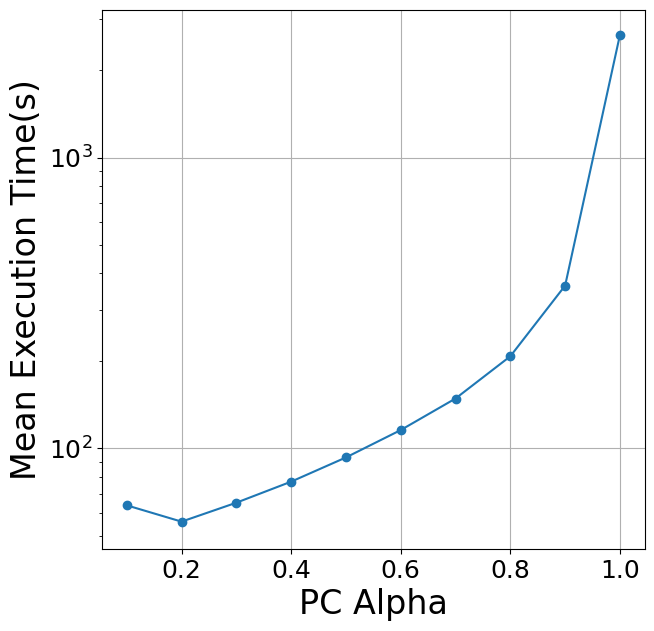

In [37]:
PCMCI_Mean_Exe_Time_Macaque = np.mean(np.array(pcmci_macaque_execution_time), axis = 0)
PCMCI_std_Exe_Time_Macaque= np.std(np.array(pcmci_macaque_execution_time), axis = 0)

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
plt.errorbar(pc_alpha, PCMCI_Mean_Exe_Time_Macaque,PCMCI_std_Exe_Time_Macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = 'o-')

plt.yscale('log')
plt.xlabel('PC Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

### Mixed-PCMCI

In [38]:
mixed_pcmci_adj_TPR_all_rep_macaque_both_alpha = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
mixed_pcmci_adj_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]

mixed_pcmci_ori_TPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
mixed_pcmci_ori_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_small

for r in range(0,num_rep_macaque_all):
    for a1 in range(0, len(pc_alpha)):
        for a2 in range(0, len(alpha_level_pcmci)):

            p_matrix = np.array(pcmci_pval_matrix_all_macaque[r][a1])
    
            # Threshold p_matrix to get graph
            final_graph_new = p_matrix <= alpha_level_pcmci[a2]
            
            # Convert to string graph representation
            graph = convert_to_string_graph(final_graph_new)

            summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_lags(graph)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_v2(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)
            
            mixed_pcmci_adj_TPR_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_TPR
            mixed_pcmci_adj_FPR_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_FPR
            mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_Recall
            mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_Precision
            mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_F1_score

            mixed_pcmci_ori_TPR_all_rep_macaque_both_alpha[r][a1][a2] = orientation_TPR
            mixed_pcmci_ori_FPR_all_rep_macaque_both_alpha[r][a1][a2]= orientation_FPR
            mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha[r][a1][a2] = orientation_Recall
            mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha[r][a1][a2]  = orientation_Precision
            mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = orientation_F1_score


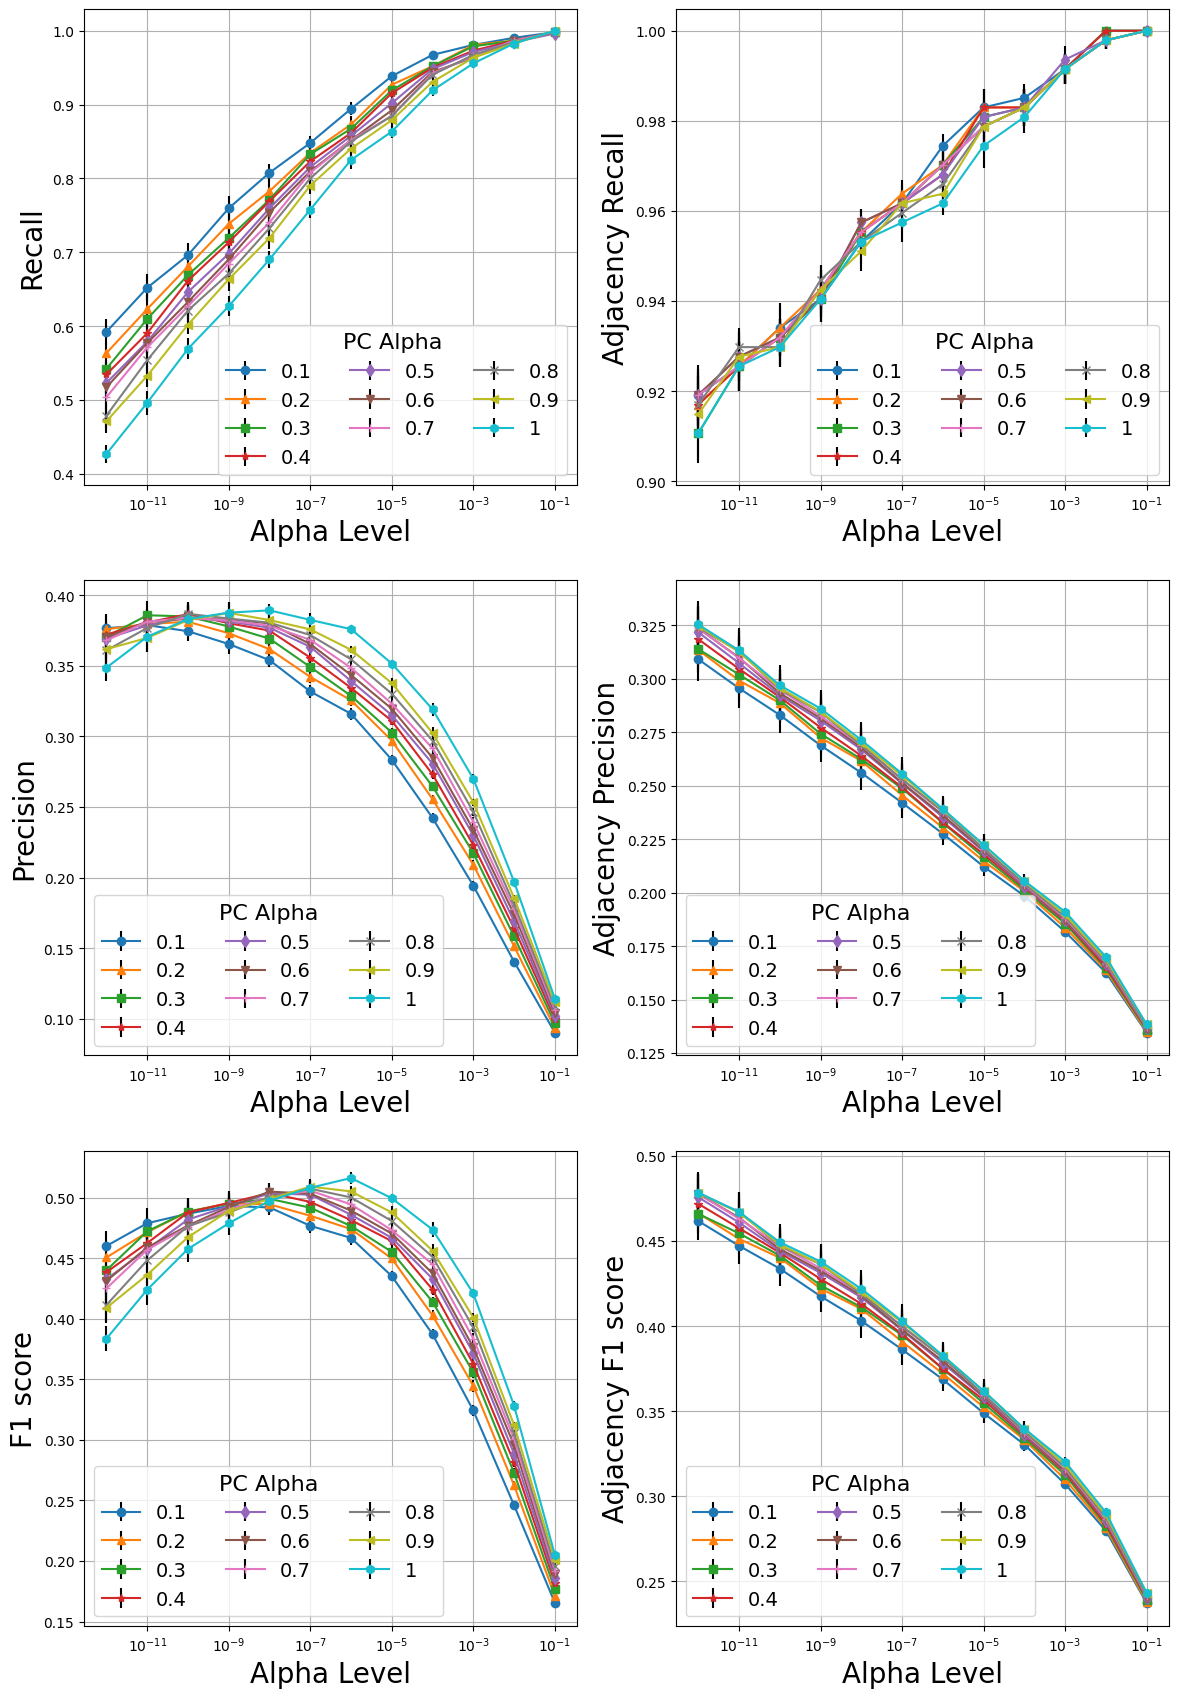

In [39]:
plt.figure(figsize = (14, 21))
markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-', 'h-']


for k in range(0, len(pc_alpha)):

    mixed_pcmci_adj_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_adj_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_adj_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    mixed_pcmci_adj_precision_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    mixed_pcmci_adj_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_adj_precision_median_macaque = np.zeros_like(alpha_level_pcmci) 

    mixed_pcmci_adj_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    mixed_pcmci_adj_F1_score_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_adj_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci) 

    mixed_pcmci_ori_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    mixed_pcmci_ori_precision_mean_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_precision_median_macaque = np.zeros_like(alpha_level_pcmci)

    mixed_pcmci_ori_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_F1_score_std_macaque =np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci)


    for a in range(0,len(alpha_level_pcmci)):

        mixed_pcmci_adj_recall_mean_macaque[a] = np.mean(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_recall_std_macaque[a] = np.std(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_recall_median_macaque[a] = np.median(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_adj_precision_mean_macaque[a] = np.mean(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_precision_std_macaque[a] = np.std(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_precision_median_macaque[a] = np.median(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_adj_F1_score_mean_macaque[a] = np.mean(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_F1_score_std_macaque[a] = np.std(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_F1_score_median_macaque[a] = np.median(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_ori_recall_mean_macaque[a] = np.mean(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_recall_std_macaque[a] = np.std(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_recall_median_macaque[a] = np.median(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_ori_precision_mean_macaque[a] = np.mean(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_precision_std_macaque[a] = np.std(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_precision_median_macaque[a] = np.median(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_ori_F1_score_mean_macaque[a] = np.mean(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_F1_score_std_macaque[a] = np.std(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_F1_score_median_macaque[a] = np.median(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])

    mixed_pcmci_best_alpha_adj_mean= alpha_level_pcmci[np.argmax(mixed_pcmci_adj_F1_score_mean_macaque)]
    mixed_pcmci_best_alpha_adj_median = alpha_level_pcmci[np.argmax(mixed_pcmci_adj_F1_score_median_macaque)]
    mixed_pcmci_best_alpha_ori_mean = alpha_level_pcmci[np.argmax(mixed_pcmci_ori_F1_score_mean_macaque)]
    mixed_pcmci_best_alpha_ori_median = alpha_level_pcmci[np.argmax(mixed_pcmci_ori_F1_score_median_macaque)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha_level_pcmci, mixed_pcmci_adj_recall_mean_macaque, mixed_pcmci_adj_recall_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha_level_pcmci, mixed_pcmci_ori_recall_mean_macaque, mixed_pcmci_ori_recall_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(alpha_level_pcmci, mixed_pcmci_adj_precision_mean_macaque, mixed_pcmci_adj_precision_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(alpha_level_pcmci, mixed_pcmci_ori_precision_mean_macaque, mixed_pcmci_ori_precision_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(alpha_level_pcmci, mixed_pcmci_adj_F1_score_mean_macaque, mixed_pcmci_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(alpha_level_pcmci, mixed_pcmci_ori_F1_score_mean_macaque, mixed_pcmci_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


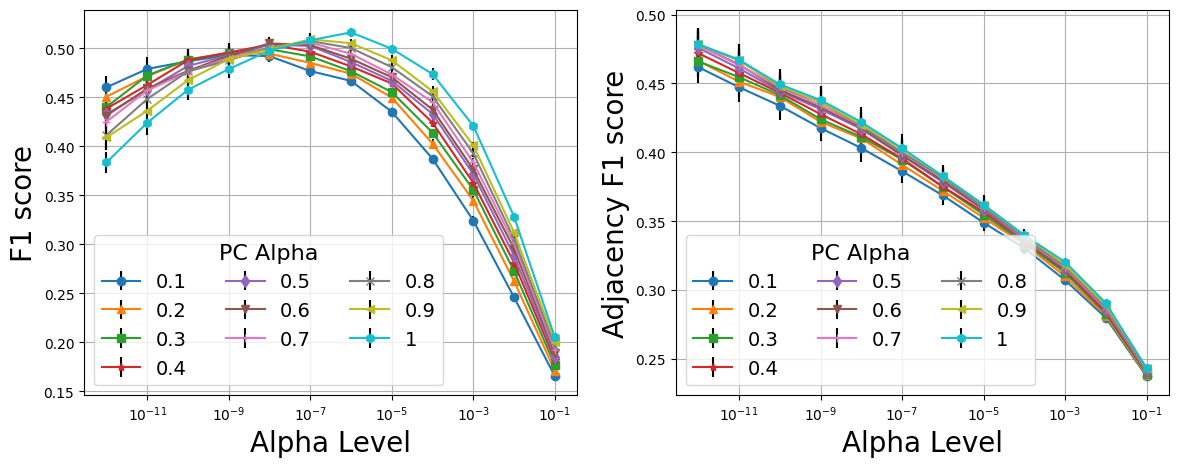

In [40]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar

plt.figure(figsize = (14, 5))
markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-', 'h-']


for k in range(0, len(pc_alpha)):

    mixed_pcmci_adj_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_adj_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_adj_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    mixed_pcmci_adj_precision_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    mixed_pcmci_adj_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_adj_precision_median_macaque = np.zeros_like(alpha_level_pcmci) 

    mixed_pcmci_adj_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    mixed_pcmci_adj_F1_score_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_adj_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci) 

    mixed_pcmci_ori_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    mixed_pcmci_ori_precision_mean_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_precision_median_macaque = np.zeros_like(alpha_level_pcmci)

    mixed_pcmci_ori_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_F1_score_std_macaque =np.zeros_like(alpha_level_pcmci)
    mixed_pcmci_ori_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci)


    for a in range(0,len(alpha_level_pcmci)):

        mixed_pcmci_adj_recall_mean_macaque[a] = np.mean(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_recall_std_macaque[a] = np.std(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_recall_median_macaque[a] = np.median(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_adj_precision_mean_macaque[a] = np.mean(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_precision_std_macaque[a] = np.std(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_precision_median_macaque[a] = np.median(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_adj_F1_score_mean_macaque[a] = np.mean(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_F1_score_std_macaque[a] = np.std(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_F1_score_median_macaque[a] = np.median(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_ori_recall_mean_macaque[a] = np.mean(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_recall_std_macaque[a] = np.std(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_recall_median_macaque[a] = np.median(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_ori_precision_mean_macaque[a] = np.mean(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_precision_std_macaque[a] = np.std(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_precision_median_macaque[a] = np.median(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_ori_F1_score_mean_macaque[a] = np.mean(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_F1_score_std_macaque[a] = np.std(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_F1_score_median_macaque[a] = np.median(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])

    mixed_pcmci_best_alpha_adj_mean= alpha_level_pcmci[np.argmax(mixed_pcmci_adj_F1_score_mean_macaque)]
    mixed_pcmci_best_alpha_adj_median = alpha_level_pcmci[np.argmax(mixed_pcmci_adj_F1_score_median_macaque)]
    mixed_pcmci_best_alpha_ori_mean = alpha_level_pcmci[np.argmax(mixed_pcmci_ori_F1_score_mean_macaque)]
    mixed_pcmci_best_alpha_ori_median = alpha_level_pcmci[np.argmax(mixed_pcmci_ori_F1_score_median_macaque)]


    plt.subplot(1,2,2)
    plt.errorbar(alpha_level_pcmci, mixed_pcmci_adj_F1_score_mean_macaque, mixed_pcmci_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(1,2,1)
    plt.errorbar(alpha_level_pcmci, mixed_pcmci_ori_F1_score_mean_macaque, mixed_pcmci_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


### PCMCI

In [41]:
pcmci_adj_TPR_all_rep_macaque_both_alpha = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
pcmci_adj_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
pcmci_adj_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
pcmci_adj_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
pcmci_adj_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]

pcmci_ori_TPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
pcmci_ori_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
pcmci_ori_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
pcmci_ori_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]
pcmci_ori_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque_all )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_small

for r in range(0,num_rep_macaque_all):
    for a1 in range(0, len(pc_alpha)):
        
        p_matrix = np.array(pcmci_pval_matrix_all_macaque[r][a1])

        for a2 in range(0, len(alpha_level_pcmci)):

    
            # Threshold p_matrix to get graph
            final_graph_new = p_matrix <= alpha_level_pcmci[a2]
            
            # Convert to string graph representation
            graph = convert_to_string_graph(final_graph_new)

            estimated_non_zero_lags_combined = find_binary_matrix_lag_non_zero_combined(graph)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr(macaque_ground_truth, estimated_non_zero_lags_combined)

            pcmci_adj_TPR_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_TPR
            pcmci_adj_FPR_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_FPR
            pcmci_adj_Recall_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_Recall
            pcmci_adj_Precision_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_Precision
            pcmci_adj_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_F1_score

            pcmci_ori_TPR_all_rep_macaque_both_alpha[r][a1][a2] = orientation_TPR
            pcmci_ori_FPR_all_rep_macaque_both_alpha[r][a1][a2]= orientation_FPR
            pcmci_ori_Recall_all_rep_macaque_both_alpha[r][a1][a2] = orientation_Recall
            pcmci_ori_Precision_all_rep_macaque_both_alpha[r][a1][a2]  = orientation_Precision
            pcmci_ori_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = orientation_F1_score


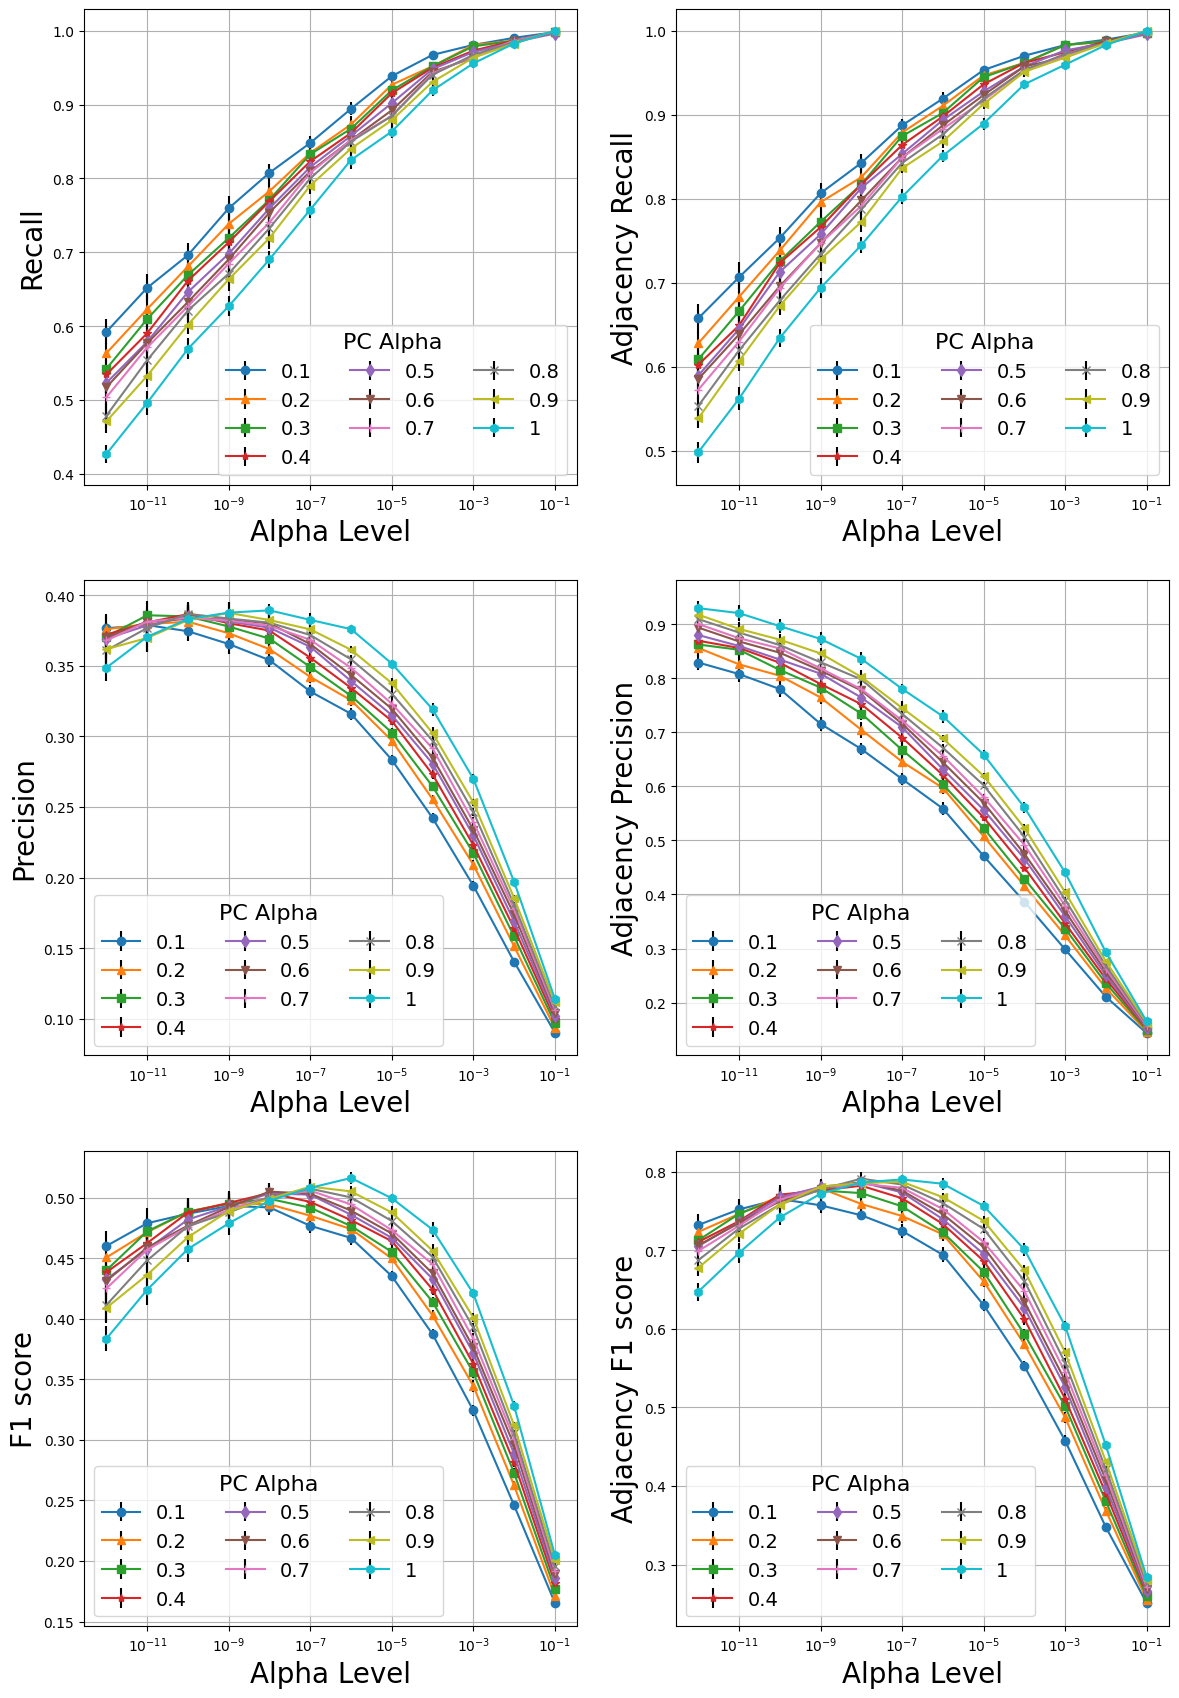

In [42]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar

plt.figure(figsize = (14, 21))
for k in range(0, len(pc_alpha)):

    pcmci_adj_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    pcmci_adj_precision_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_precision_median_macaque = np.zeros_like(alpha_level_pcmci) 

    pcmci_adj_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_F1_score_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci) 

    pcmci_ori_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    pcmci_ori_precision_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_median_macaque = np.zeros_like(alpha_level_pcmci)

    pcmci_ori_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_std_macaque =np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci)


    for a in range(0,len(alpha_level_pcmci)):

        pcmci_adj_recall_mean_macaque[a] = np.mean(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_recall_std_macaque[a] = np.std(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_recall_median_macaque[a] = np.median(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_adj_precision_mean_macaque[a] = np.mean(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_precision_std_macaque[a] = np.std(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_precision_median_macaque[a] = np.median(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_adj_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_F1_score_std_macaque[a] = np.std(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_F1_score_median_macaque[a] = np.median(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_recall_mean_macaque[a] = np.mean(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_recall_std_macaque[a] = np.std(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_recall_median_macaque[a] = np.median(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_precision_mean_macaque[a] = np.mean(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_precision_std_macaque[a] = np.std(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_precision_median_macaque[a] = np.median(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_F1_score_std_macaque[a] = np.std(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_F1_score_median_macaque[a] = np.median(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])

    plt.subplot(3,2,2)
    plt.errorbar(alpha_level_pcmci, pcmci_adj_recall_mean_macaque, pcmci_adj_recall_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha_level_pcmci, pcmci_ori_recall_mean_macaque, pcmci_ori_recall_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(alpha_level_pcmci, pcmci_adj_precision_mean_macaque, pcmci_adj_precision_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(alpha_level_pcmci, pcmci_ori_precision_mean_macaque, pcmci_ori_precision_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(alpha_level_pcmci, pcmci_adj_F1_score_mean_macaque, pcmci_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(alpha_level_pcmci, pcmci_ori_F1_score_mean_macaque, pcmci_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


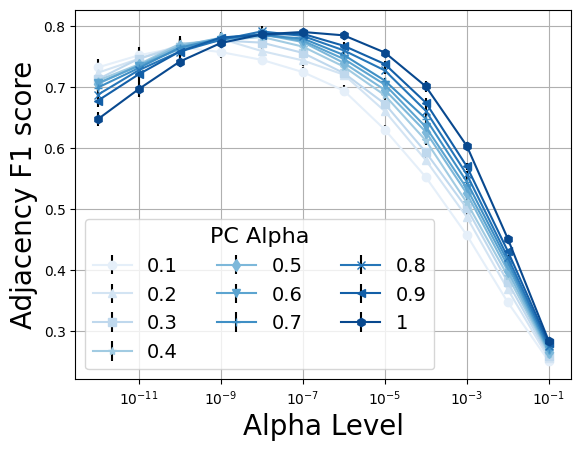

In [43]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar
from matplotlib.cm import Blues

for k in range(0, len(pc_alpha)):

    pcmci_adj_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    pcmci_adj_precision_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_precision_median_macaque = np.zeros_like(alpha_level_pcmci) 

    pcmci_adj_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_F1_score_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci) 

    pcmci_ori_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    pcmci_ori_precision_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_median_macaque = np.zeros_like(alpha_level_pcmci)

    pcmci_ori_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_std_macaque =np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci)


    for a in range(0,len(alpha_level_pcmci)):

        pcmci_adj_recall_mean_macaque[a] = np.mean(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_recall_std_macaque[a] = np.std(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_recall_median_macaque[a] = np.median(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_adj_precision_mean_macaque[a] = np.mean(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_precision_std_macaque[a] = np.std(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_precision_median_macaque[a] = np.median(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_adj_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_F1_score_std_macaque[a] = np.std(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_F1_score_median_macaque[a] = np.median(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_recall_mean_macaque[a] = np.mean(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_recall_std_macaque[a] = np.std(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_recall_median_macaque[a] = np.median(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_precision_mean_macaque[a] = np.mean(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_precision_std_macaque[a] = np.std(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_precision_median_macaque[a] = np.median(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_F1_score_std_macaque[a] = np.std(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_F1_score_median_macaque[a] = np.median(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])


    plt.errorbar(alpha_level_pcmci, pcmci_adj_F1_score_mean_macaque, pcmci_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k], color = sns.color_palette('Blues', n_colors= len(pc_alpha))[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


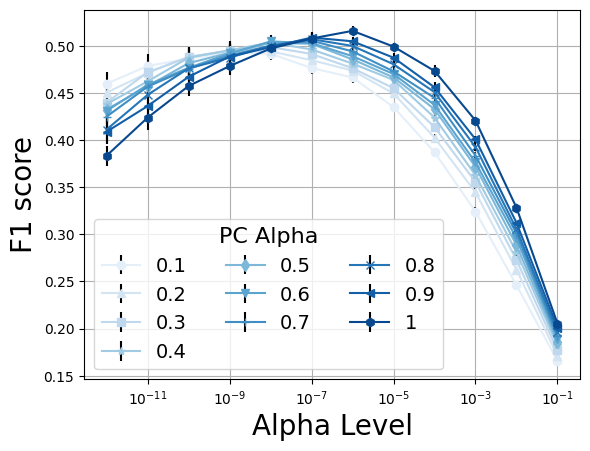

In [44]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar

for k in range(0, len(pc_alpha)):

    pcmci_adj_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    pcmci_adj_precision_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_precision_median_macaque = np.zeros_like(alpha_level_pcmci) 

    pcmci_adj_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_F1_score_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci) 

    pcmci_ori_recall_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_median_macaque = np.zeros_like(alpha_level_pcmci)

    pcmci_ori_precision_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_std_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_median_macaque = np.zeros_like(alpha_level_pcmci)

    pcmci_ori_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_std_macaque =np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci)


    for a in range(0,len(alpha_level_pcmci)):

        pcmci_adj_recall_mean_macaque[a] = np.mean(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_recall_std_macaque[a] = np.std(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_recall_median_macaque[a] = np.median(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_adj_precision_mean_macaque[a] = np.mean(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_precision_std_macaque[a] = np.std(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_precision_median_macaque[a] = np.median(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_adj_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_F1_score_std_macaque[a] = np.std(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_F1_score_median_macaque[a] = np.median(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_recall_mean_macaque[a] = np.mean(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_recall_std_macaque[a] = np.std(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_recall_median_macaque[a] = np.median(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_precision_mean_macaque[a] = np.mean(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_precision_std_macaque[a] = np.std(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_precision_median_macaque[a] = np.median(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_F1_score_std_macaque[a] = np.std(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_F1_score_median_macaque[a] = np.median(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])

    plt.errorbar(alpha_level_pcmci, pcmci_ori_F1_score_mean_macaque, pcmci_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k], color = sns.color_palette('Blues', n_colors= len(pc_alpha))[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(pc_alpha, fontsize = 14, loc = 'best', ncol = 3, title = 'PC Alpha', title_fontsize = 16)


## VARLiNGAM

### Varlingam Execution Time

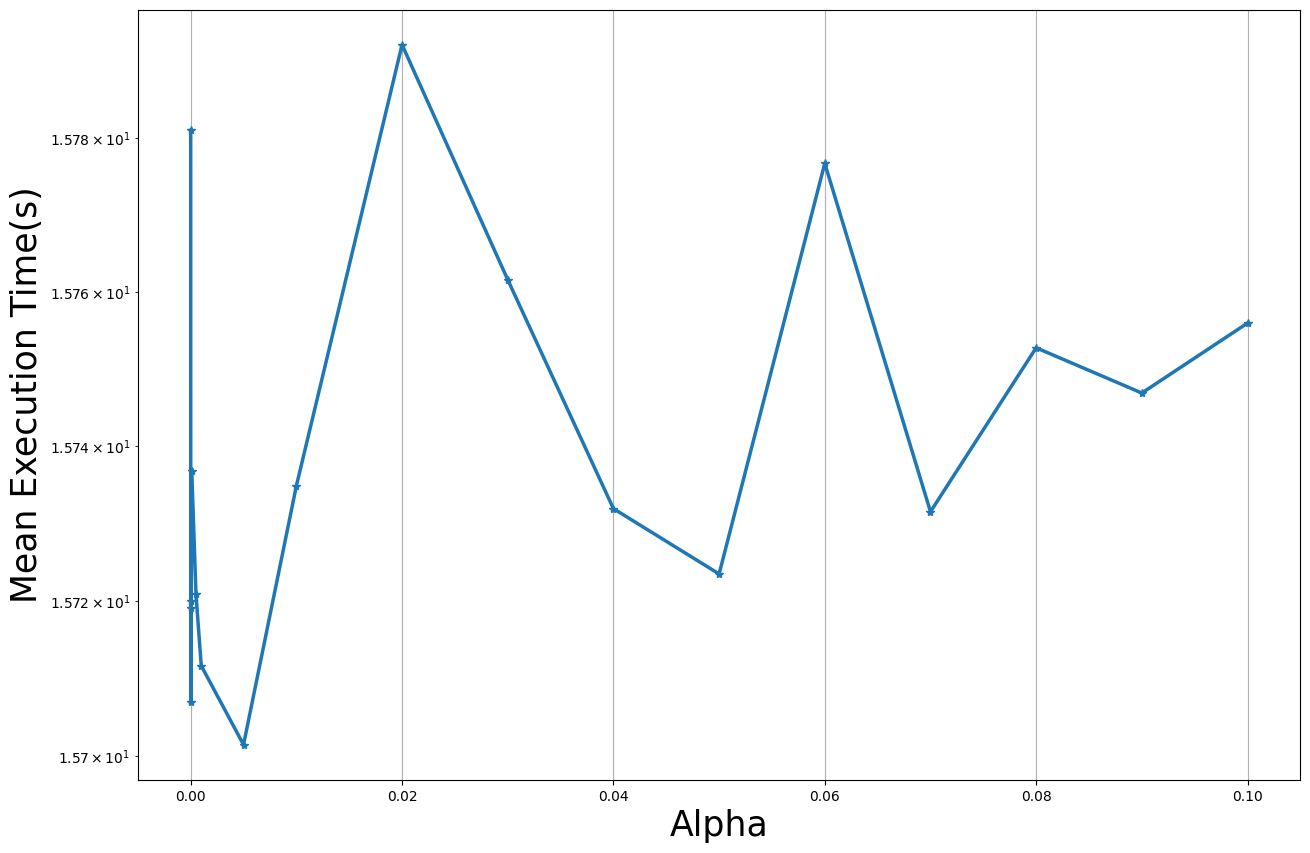

In [45]:
Varlingam_Mean_Exe_Time_Macaque = np.zeros((len(alpha),1))

for a in range(0, len(alpha)):
    Varlingam_Mean_Exe_Time_Macaque[a] = np.mean(varlingam_macaque_execution_time[:,a])

plt.figure(figsize = (15,10))
plt.plot(alpha, Varlingam_Mean_Exe_Time_Macaque, '-*', linewidth = 2.5)
plt.yscale('log')
plt.xlabel('Alpha', fontsize = 25)
plt.ylabel('Mean Execution Time(s)', fontsize = 25)
plt.grid()

In [46]:
varlingam_adj_TPR_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_adj_FPR_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_adj_Recall_all_rep_macaque =[['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_adj_Precision_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_adj_F1_score_all_rep_macaque =[['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]

varlingam_ori_TPR_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_ori_FPR_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_ori_Recall_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_ori_Precision_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_ori_F1_score_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]

macaque_ground_truth = ground_truth_graph_matrix_macaques_small

for r in range(0,num_rep_macaque):
    for a in range(0, len(alpha)):

        PAG = np.array(varlingam_link_matrix_macaque[r][a])
        
        summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_lags(PAG)
        adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_v2(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)


        varlingam_adj_TPR_all_rep_macaque[r][a] = adjacency_TPR
        varlingam_adj_FPR_all_rep_macaque[r][a]  = adjacency_FPR
        varlingam_adj_Recall_all_rep_macaque[r][a]  = adjacency_Recall
        varlingam_adj_Precision_all_rep_macaque[r][a] = adjacency_Precision
        varlingam_adj_F1_score_all_rep_macaque[r][a]  = adjacency_F1_score

        varlingam_ori_TPR_all_rep_macaque[r][a]  = orientation_TPR
        varlingam_ori_FPR_all_rep_macaque[r][a] = orientation_FPR
        varlingam_ori_Recall_all_rep_macaque[r][a] = orientation_Recall
        varlingam_ori_Precision_all_rep_macaque[r][a]  = orientation_Precision
        varlingam_ori_F1_score_all_rep_macaque[r][a]  = orientation_F1_score

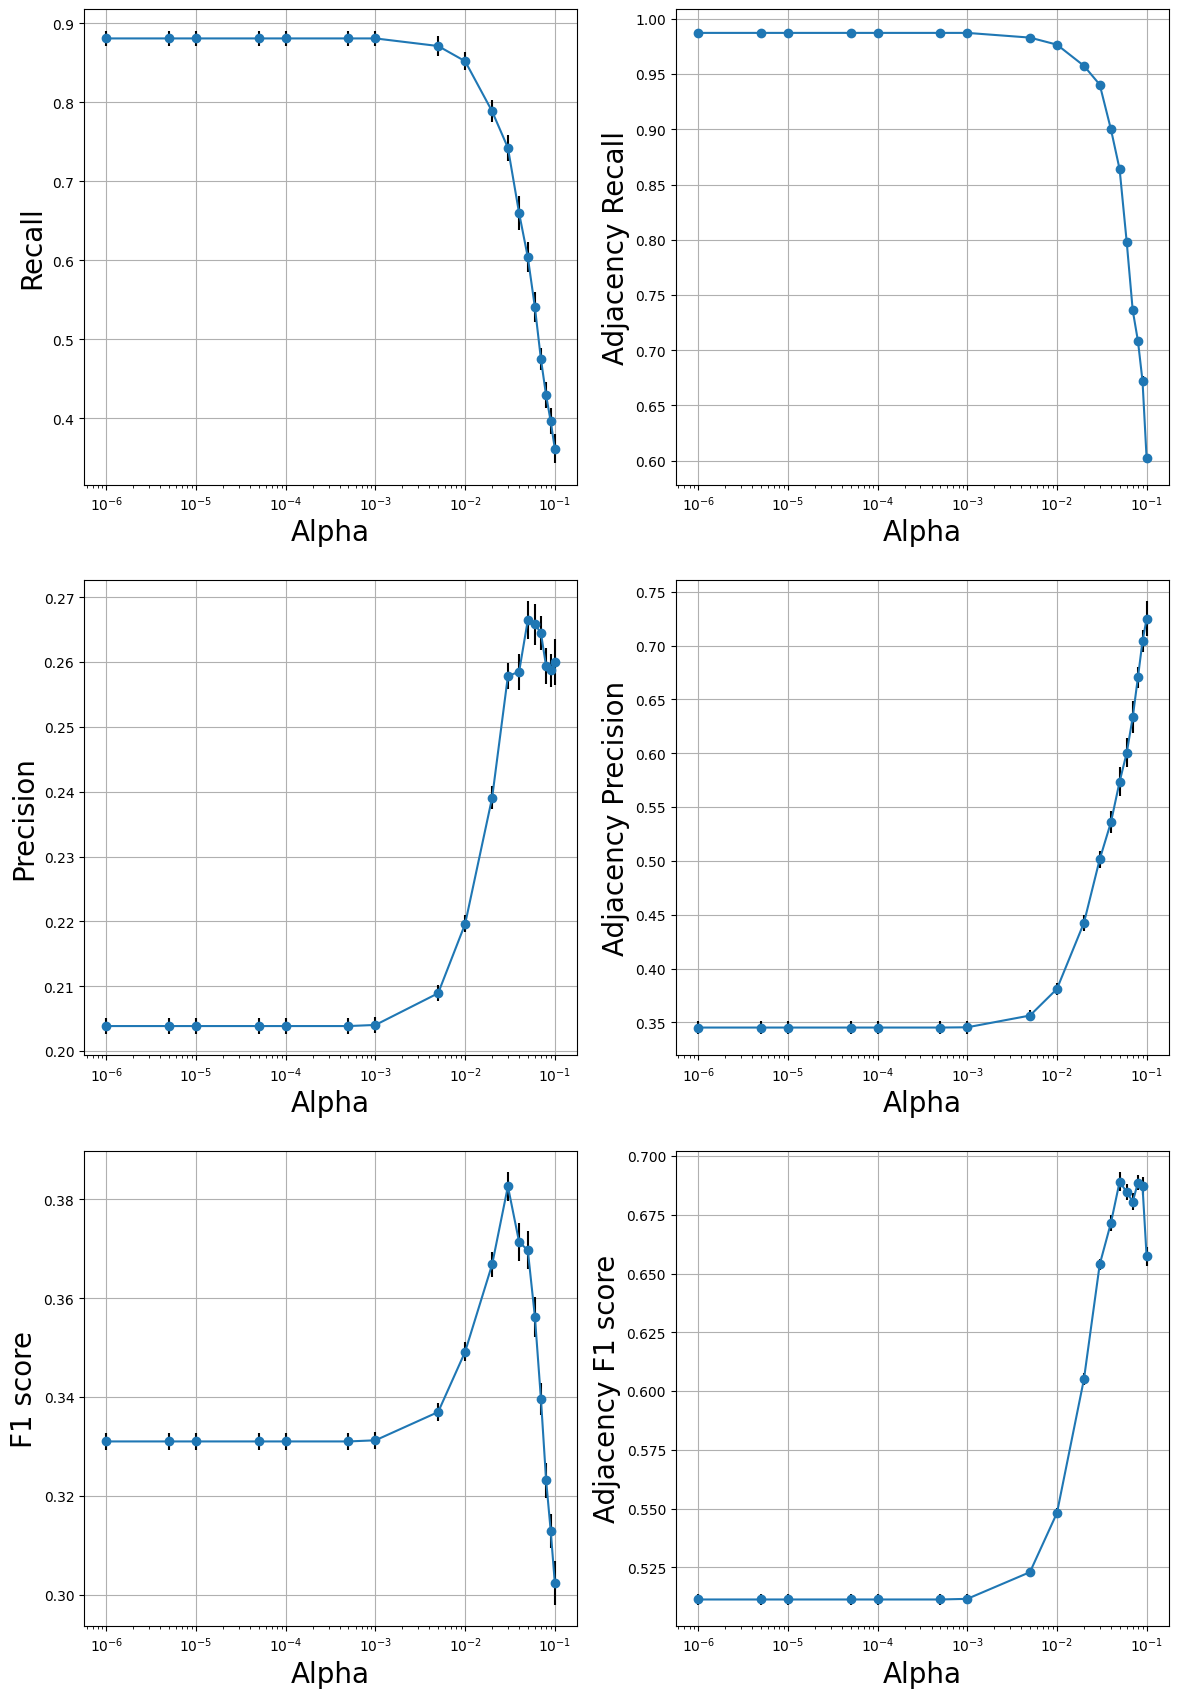

In [47]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar

plt.figure(figsize = (14,21))

varlingam_adj_recall_mean_macaque = np.zeros_like(alpha)
varlingam_adj_recall_std_macaque = np.zeros_like(alpha)
varlingam_adj_recall_median_macaque = np.zeros_like(alpha)

varlingam_adj_precision_mean_macaque = np.zeros_like(alpha) 
varlingam_adj_precision_std_macaque = np.zeros_like(alpha)
varlingam_adj_precision_median_macaque = np.zeros_like(alpha) 

varlingam_adj_F1_score_mean_macaque = np.zeros_like(alpha) 
varlingam_adj_F1_score_std_macaque = np.zeros_like(alpha)
varlingam_adj_F1_score_median_macaque = np.zeros_like(alpha) 

varlingam_ori_recall_mean_macaque = np.zeros_like(alpha)
varlingam_ori_recall_std_macaque = np.zeros_like(alpha)
varlingam_ori_recall_median_macaque = np.zeros_like(alpha)

varlingam_ori_precision_mean_macaque = np.zeros_like(alpha)
varlingam_ori_precision_std_macaque = np.zeros_like(alpha)
varlingam_ori_precision_median_macaque = np.zeros_like(alpha)

varlingam_ori_F1_score_mean_macaque = np.zeros_like(alpha)
varlingam_ori_F1_score_std_macaque =np.zeros_like(alpha)
varlingam_ori_F1_score_median_macaque = np.zeros_like(alpha)


for a in range(0,len(alpha)):

    varlingam_adj_recall_mean_macaque[a] = np.mean(np.array(varlingam_adj_Recall_all_rep_macaque)[:,a])
    varlingam_adj_recall_std_macaque[a] = np.std(np.array(varlingam_adj_Recall_all_rep_macaque)[:,a])
    varlingam_adj_recall_median_macaque[a] = np.median(np.array(varlingam_adj_Recall_all_rep_macaque)[:,a])


    varlingam_adj_precision_mean_macaque[a] = np.mean(np.array(varlingam_adj_Precision_all_rep_macaque)[:,a])
    varlingam_adj_precision_std_macaque[a] = np.std(np.array(varlingam_adj_Precision_all_rep_macaque)[:,a])
    varlingam_adj_precision_median_macaque[a] = np.median(np.array(varlingam_adj_Precision_all_rep_macaque)[:,a])


    varlingam_adj_F1_score_mean_macaque[a] = np.mean(np.array(varlingam_adj_F1_score_all_rep_macaque)[:,a])
    varlingam_adj_F1_score_std_macaque[a] = np.std(np.array(varlingam_adj_F1_score_all_rep_macaque)[:,a])
    varlingam_adj_F1_score_median_macaque[a] = np.median(np.array(varlingam_adj_F1_score_all_rep_macaque)[:,a])


    varlingam_ori_recall_mean_macaque[a] = np.mean(np.array(varlingam_ori_Recall_all_rep_macaque)[:,a])
    varlingam_ori_recall_std_macaque[a] = np.std(np.array(varlingam_ori_Recall_all_rep_macaque)[:,a])
    varlingam_ori_recall_median_macaque[a] = np.median(np.array(varlingam_ori_Recall_all_rep_macaque)[:,a])


    varlingam_ori_precision_mean_macaque[a] = np.mean(np.array(varlingam_ori_Precision_all_rep_macaque)[:,a])
    varlingam_ori_precision_std_macaque[a] = np.std(np.array(varlingam_ori_Precision_all_rep_macaque)[:,a])
    varlingam_ori_precision_median_macaque[a] = np.median(np.array(varlingam_ori_Precision_all_rep_macaque)[:,a])


    varlingam_ori_F1_score_mean_macaque[a] = np.mean(np.array(varlingam_ori_F1_score_all_rep_macaque)[:,a])
    varlingam_ori_F1_score_std_macaque[a] = np.std(np.array(varlingam_ori_F1_score_all_rep_macaque)[:,a])
    varlingam_ori_F1_score_median_macaque[a] = np.median(np.array(varlingam_ori_F1_score_all_rep_macaque)[:,a])

varlingam_1_best_alpha_adj_mean= alpha[np.argmax(varlingam_adj_F1_score_mean_macaque)]
varlingam_1_best_alpha_adj_median = alpha[np.argmax(varlingam_adj_F1_score_median_macaque)]
varlingam_1_best_alpha_ori_mean = alpha[np.argmax(varlingam_ori_F1_score_mean_macaque)]
varlingam_1_best_alpha_ori_median = alpha[np.argmax(varlingam_ori_F1_score_median_macaque)]

plt.subplot(3,2,2)
plt.errorbar(alpha, varlingam_adj_recall_mean_macaque, varlingam_adj_recall_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.xscale('log')
plt.ylabel('Adjacency Recall', fontsize = 20)
plt.grid()

plt.subplot(3,2,1)
plt.errorbar(alpha, varlingam_ori_recall_mean_macaque, varlingam_ori_recall_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.xscale('log')
plt.xscale('log')
plt.grid()


plt.subplot(3,2,4)
plt.errorbar(alpha, varlingam_adj_precision_mean_macaque, varlingam_adj_precision_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.xscale('log')
plt.ylabel('Adjacency Precision', fontsize = 20)
plt.grid()

plt.subplot(3,2,3)
plt.errorbar(alpha, varlingam_ori_precision_mean_macaque, varlingam_ori_precision_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.xscale('log')
plt.grid()

plt.subplot(3,2,6)
plt.errorbar(alpha, varlingam_adj_F1_score_mean_macaque, varlingam_adj_F1_score_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency F1 score', fontsize = 20)
plt.xscale('log')
plt.grid()

plt.subplot(3,2,5)
plt.errorbar(alpha, varlingam_ori_F1_score_mean_macaque, varlingam_ori_F1_score_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.xscale('log')
plt.grid()


## Dynotears

### Dynotears Execution Time

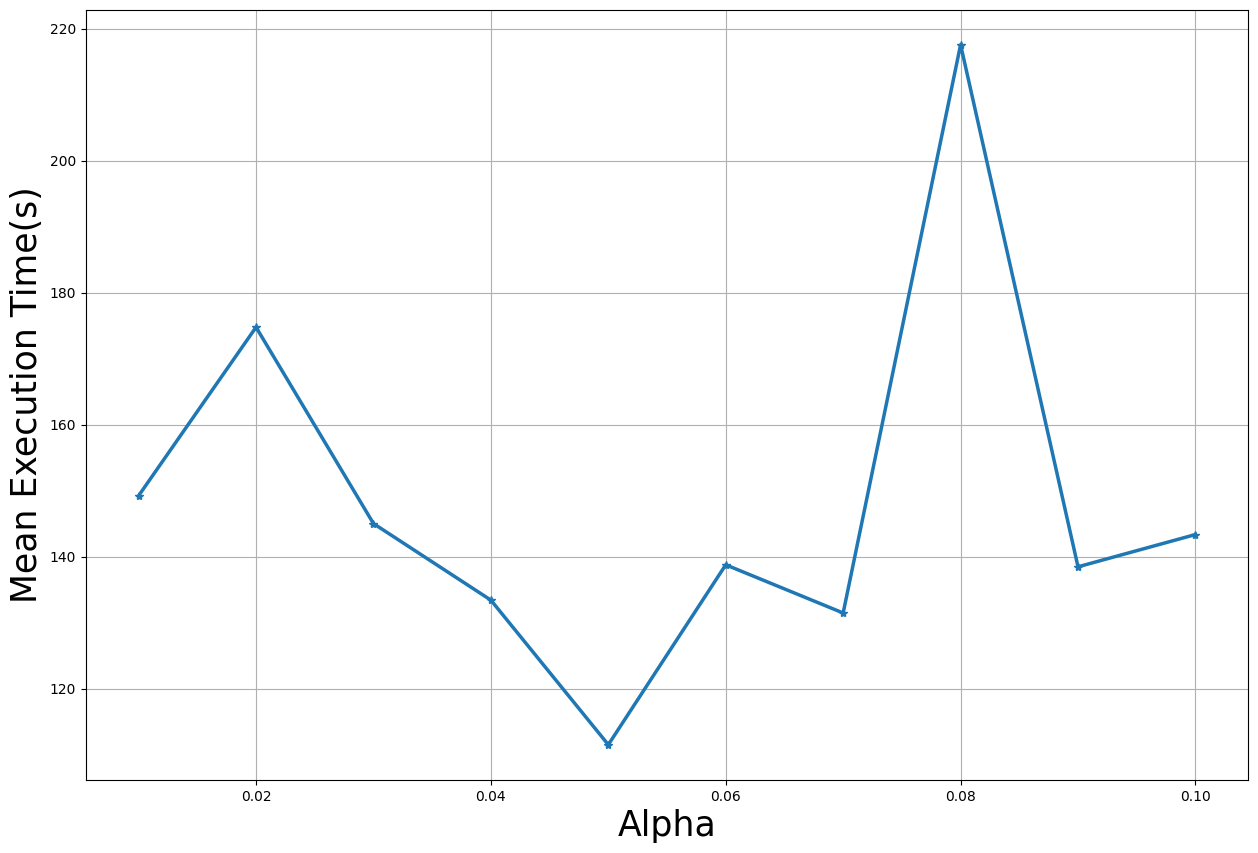

In [48]:
Dynotears_Mean_Exe_Time_Macaque = np.zeros((len(alpha_dynotears),1))

for a in range(0, len(alpha_dynotears)):
    Dynotears_Mean_Exe_Time_Macaque[a] = np.mean(dynotears_macaque_execution_time[:][a])

plt.figure(figsize = (15,10))
plt.plot(alpha_dynotears, Dynotears_Mean_Exe_Time_Macaque, '-*', linewidth = 2.5)
plt.xlabel('Alpha', fontsize = 25)
plt.ylabel('Mean Execution Time(s)', fontsize = 25)
plt.grid()

### DYNOTEARS

In [49]:
dynotears_adj_TPR_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]
dynotears_adj_FPR_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]
dynotears_adj_Recall_all_rep_macaque =[['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]
dynotears_adj_Precision_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]
dynotears_adj_F1_score_all_rep_macaque =[['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]

dynotears_ori_TPR_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]
dynotears_ori_FPR_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]
dynotears_ori_Recall_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]
dynotears_ori_Precision_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]
dynotears_ori_F1_score_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque)]

macaque_ground_truth = ground_truth_graph_matrix_macaques_small

for r in range(0,num_rep_macaque):
    for a in range(0, len(alpha_dynotears)):

        PAG = np.array(dynotears_link_matrix_all_macaque[r][a])

        summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_lags(PAG)
        adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_v2(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)

        dynotears_adj_TPR_all_rep_macaque[r][a] = adjacency_TPR
        dynotears_adj_FPR_all_rep_macaque[r][a]  = adjacency_FPR
        dynotears_adj_Recall_all_rep_macaque[r][a]  = adjacency_Recall
        dynotears_adj_Precision_all_rep_macaque[r][a] = adjacency_Precision
        dynotears_adj_F1_score_all_rep_macaque[r][a]  = adjacency_F1_score

        dynotears_ori_TPR_all_rep_macaque[r][a]  = orientation_TPR
        dynotears_ori_FPR_all_rep_macaque[r][a] = orientation_FPR
        dynotears_ori_Recall_all_rep_macaque[r][a] = orientation_Recall
        dynotears_ori_Precision_all_rep_macaque[r][a]  = orientation_Precision
        dynotears_ori_F1_score_all_rep_macaque[r][a]  = orientation_F1_score

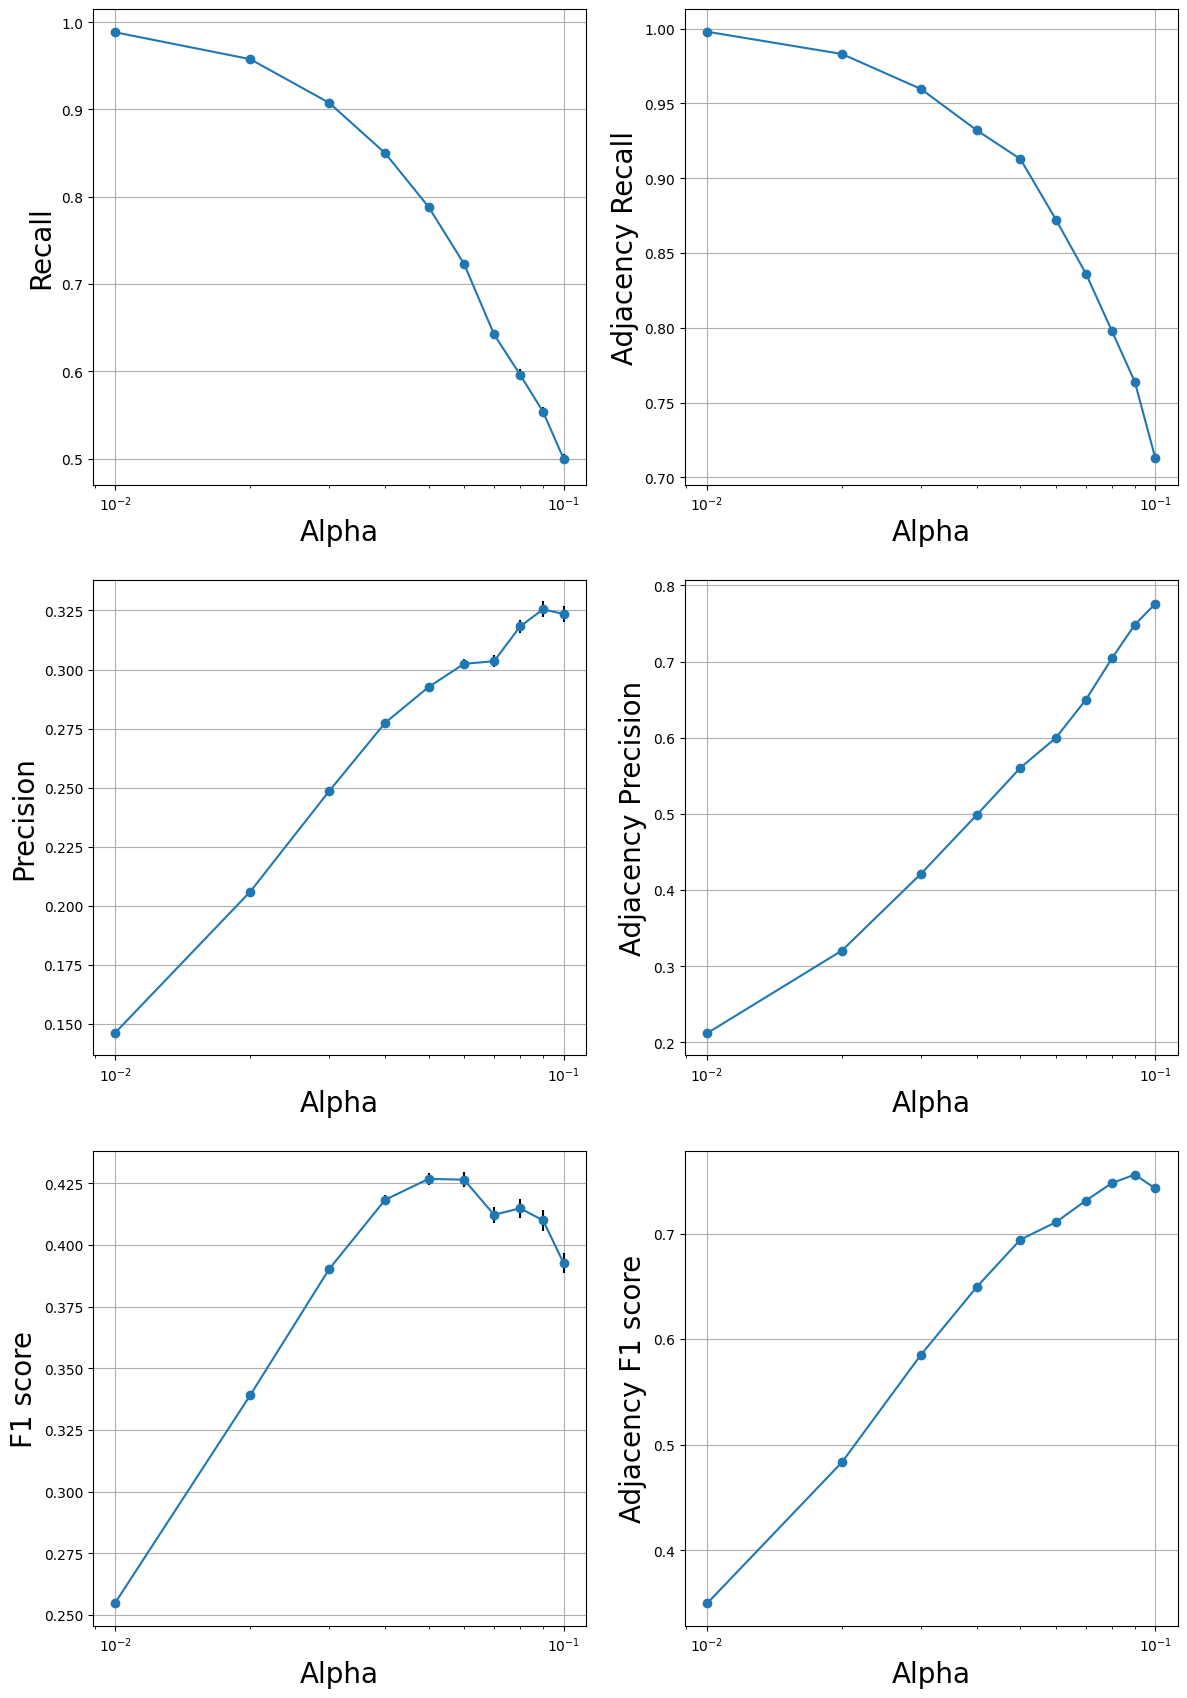

In [50]:

plt.figure(figsize = (14, 21))

dynotears_adj_recall_mean_macaque = np.zeros_like(alpha_dynotears)
dynotears_adj_recall_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_adj_recall_median_macaque = np.zeros_like(alpha_dynotears)

dynotears_adj_precision_mean_macaque = np.zeros_like(alpha_dynotears) 
dynotears_adj_precision_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_adj_precision_median_macaque = np.zeros_like(alpha_dynotears) 

dynotears_adj_F1_score_mean_macaque = np.zeros_like(alpha_dynotears) 
dynotears_adj_F1_score_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_adj_F1_score_median_macaque = np.zeros_like(alpha_dynotears) 

dynotears_ori_recall_mean_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_recall_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_recall_median_macaque = np.zeros_like(alpha_dynotears)

dynotears_ori_precision_mean_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_precision_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_precision_median_macaque = np.zeros_like(alpha_dynotears)

dynotears_ori_F1_score_mean_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_F1_score_std_macaque =np.zeros_like(alpha_dynotears)
dynotears_ori_F1_score_median_macaque = np.zeros_like(alpha_dynotears)

for a in range(0,len(alpha_dynotears)):

    dynotears_adj_recall_mean_macaque[a] = np.mean(np.array(dynotears_adj_Recall_all_rep_macaque)[:,a])
    dynotears_adj_recall_std_macaque[a] = np.std(np.array(dynotears_adj_Recall_all_rep_macaque)[:,a])
    dynotears_adj_recall_median_macaque[a] = np.median(np.array(dynotears_adj_Recall_all_rep_macaque)[:,a])


    dynotears_adj_precision_mean_macaque[a] = np.mean(np.array(dynotears_adj_Precision_all_rep_macaque)[:,a])
    dynotears_adj_precision_std_macaque[a] = np.std(np.array(dynotears_adj_Precision_all_rep_macaque)[:,a])
    dynotears_adj_precision_median_macaque[a] = np.median(np.array(dynotears_adj_Precision_all_rep_macaque)[:,a])


    dynotears_adj_F1_score_mean_macaque[a] = np.mean(np.array(dynotears_adj_F1_score_all_rep_macaque)[:,a])
    dynotears_adj_F1_score_std_macaque[a] = np.std(np.array(dynotears_adj_F1_score_all_rep_macaque)[:,a])
    dynotears_adj_F1_score_median_macaque[a] = np.median(np.array(dynotears_adj_F1_score_all_rep_macaque)[:,a])


    dynotears_ori_recall_mean_macaque[a] = np.mean(np.array(dynotears_ori_Recall_all_rep_macaque)[:,a])
    dynotears_ori_recall_std_macaque[a] = np.std(np.array(dynotears_ori_Recall_all_rep_macaque)[:,a])
    dynotears_ori_recall_median_macaque[a] = np.median(np.array(dynotears_ori_Recall_all_rep_macaque)[:,a])


    dynotears_ori_precision_mean_macaque[a] = np.mean(np.array(dynotears_ori_Precision_all_rep_macaque)[:,a])
    dynotears_ori_precision_std_macaque[a] = np.std(np.array(dynotears_ori_Precision_all_rep_macaque)[:,a])
    dynotears_ori_precision_median_macaque[a] = np.median(np.array(dynotears_ori_Precision_all_rep_macaque)[:,a])

    dynotears_ori_F1_score_mean_macaque[a] = np.mean(np.array(dynotears_ori_F1_score_all_rep_macaque)[:,a])
    dynotears_ori_F1_score_std_macaque[a] = np.std(np.array(dynotears_ori_F1_score_all_rep_macaque)[:,a])
    dynotears_ori_F1_score_median_macaque[a] = np.median(np.array(dynotears_ori_F1_score_all_rep_macaque)[:,a])

dynotears_1_best_alpha_adj_mean= alpha_dynotears[np.argmax(dynotears_adj_F1_score_mean_macaque)]
dynotears_1_best_alpha_adj_median = alpha_dynotears[np.argmax(dynotears_adj_F1_score_median_macaque)]
dynotears_1_best_alpha_ori_mean = alpha_dynotears[np.argmax(dynotears_ori_F1_score_mean_macaque)]
dynotears_1_best_alpha_ori_median = alpha_dynotears[np.argmax(dynotears_ori_F1_score_median_macaque)]

plt.subplot(3,2,2)
plt.errorbar(alpha_dynotears, dynotears_adj_recall_mean_macaque, dynotears_adj_recall_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.xscale('log')
plt.ylabel('Adjacency Recall', fontsize = 20)
plt.grid()

plt.subplot(3,2,1)
plt.errorbar(alpha_dynotears, dynotears_ori_recall_mean_macaque, dynotears_ori_recall_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.xscale('log')
plt.xscale('log')
plt.grid()


plt.subplot(3,2,4)
plt.errorbar(alpha_dynotears, dynotears_adj_precision_mean_macaque, dynotears_adj_precision_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.xscale('log')
plt.ylabel('Adjacency Precision', fontsize = 20)
plt.grid()

plt.subplot(3,2,3)
plt.errorbar(alpha_dynotears, dynotears_ori_precision_mean_macaque, dynotears_ori_precision_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.xscale('log')
plt.grid()

plt.subplot(3,2,6)
plt.errorbar(alpha_dynotears, dynotears_adj_F1_score_mean_macaque, dynotears_adj_F1_score_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency F1 score', fontsize = 20)
plt.xscale('log')
plt.grid()

plt.subplot(3,2,5)
plt.errorbar(alpha_dynotears, dynotears_ori_F1_score_mean_macaque, dynotears_ori_F1_score_std_macaque/num_rep_macaque_all, ecolor = 'black', fmt = 'o-')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.xscale('log')
plt.grid()

## MVGC (Multivariate Granger Causality)

### Execution Time for MVGC

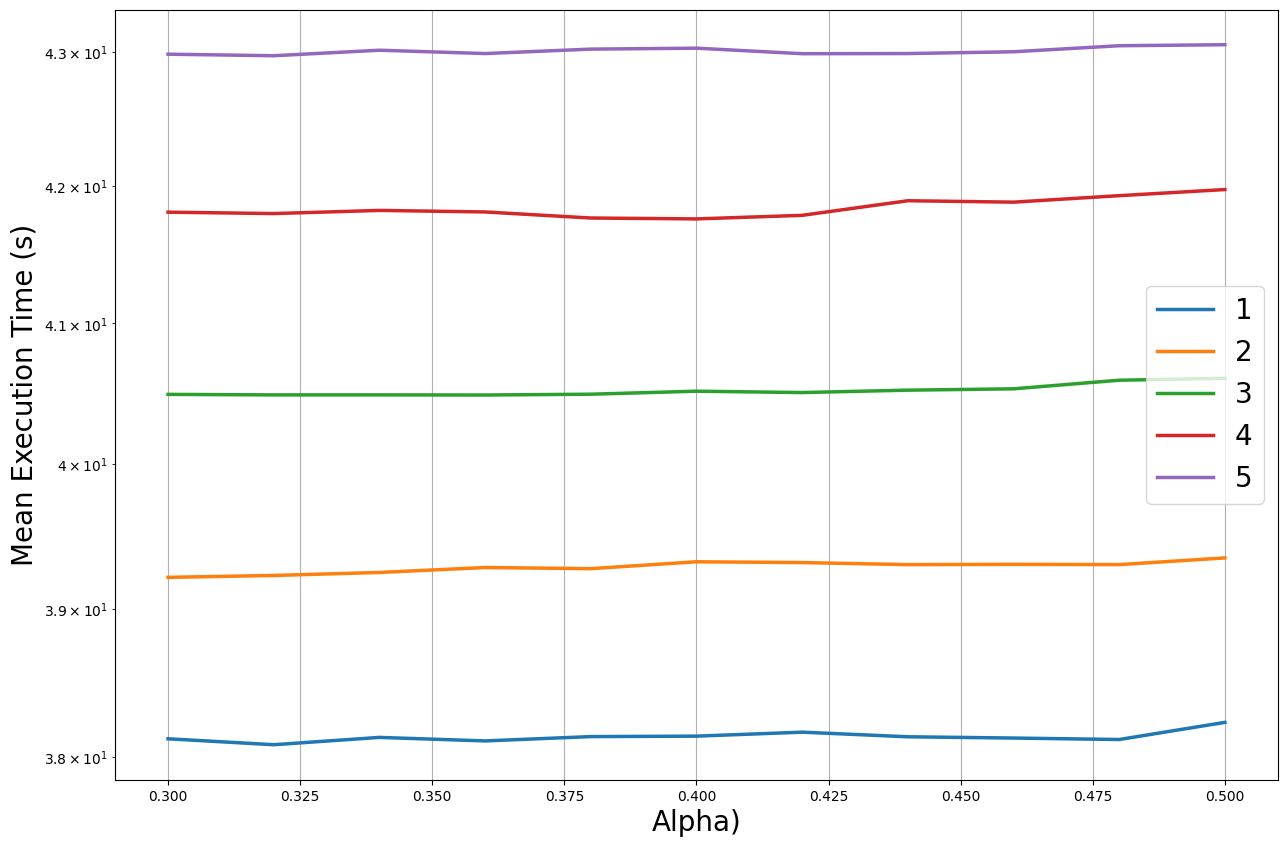

In [51]:
MVGC_Mean_Exe_Time_Macaque = np.zeros((len(mvgc_lags), len(mvgc_alpha)))
plt.figure(figsize = (15,10))

for l in range(0,len(mvgc_lags)):
    for a in range(0, len(mvgc_alpha)):
        MVGC_Mean_Exe_Time_Macaque[l][a] = np.mean(np.array(mvgc_macaque_execution_time)[:,l,a])

    plt.plot(mvgc_alpha, MVGC_Mean_Exe_Time_Macaque[:][l], linewidth = 2.5)
    plt.yscale('log')
    plt.xlabel('Alpha)', fontsize = 20)
    plt.ylabel('Mean Execution Time (s)', fontsize = 20)
    plt.grid()
plt.legend(mvgc_lags,fontsize = 20)

### MVGC Performance

In [52]:
mvgc_adj_TPR_all_rep_macaque_both_alpha = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]
mvgc_adj_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]
mvgc_adj_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]
mvgc_adj_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]
mvgc_adj_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]

mvgc_ori_TPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]
mvgc_ori_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]
mvgc_ori_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]
mvgc_ori_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]
mvgc_ori_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque_all )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_small

for r in range(0,num_rep_macaque_all):
    for l in range(0, len(mvgc_lags)):
        for a in range(0, len(mvgc_alpha)):

            DAG = np.array(mvgc_link_matrix_all_macaque[r][l][a])-1
            estimated_non_zero_lags_combined = DAG
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr(macaque_ground_truth, estimated_non_zero_lags_combined)

            mvgc_adj_TPR_all_rep_macaque_both_alpha[r][l][a] = adjacency_TPR
            mvgc_adj_FPR_all_rep_macaque_both_alpha[r][l][a]  = adjacency_FPR
            mvgc_adj_Recall_all_rep_macaque_both_alpha[r][l][a]  = adjacency_Recall
            mvgc_adj_Precision_all_rep_macaque_both_alpha[r][l][a] = adjacency_Precision
            mvgc_adj_F1_score_all_rep_macaque_both_alpha[r][l][a] = adjacency_F1_score

            mvgc_ori_TPR_all_rep_macaque_both_alpha[r][l][a] = orientation_TPR
            mvgc_ori_FPR_all_rep_macaque_both_alpha[r][l][a]= orientation_FPR
            mvgc_ori_Recall_all_rep_macaque_both_alpha[r][l][a] = orientation_Recall
            mvgc_ori_Precision_all_rep_macaque_both_alpha[r][l][a]  = orientation_Precision
            mvgc_ori_F1_score_all_rep_macaque_both_alpha[r][l][a] = orientation_F1_score


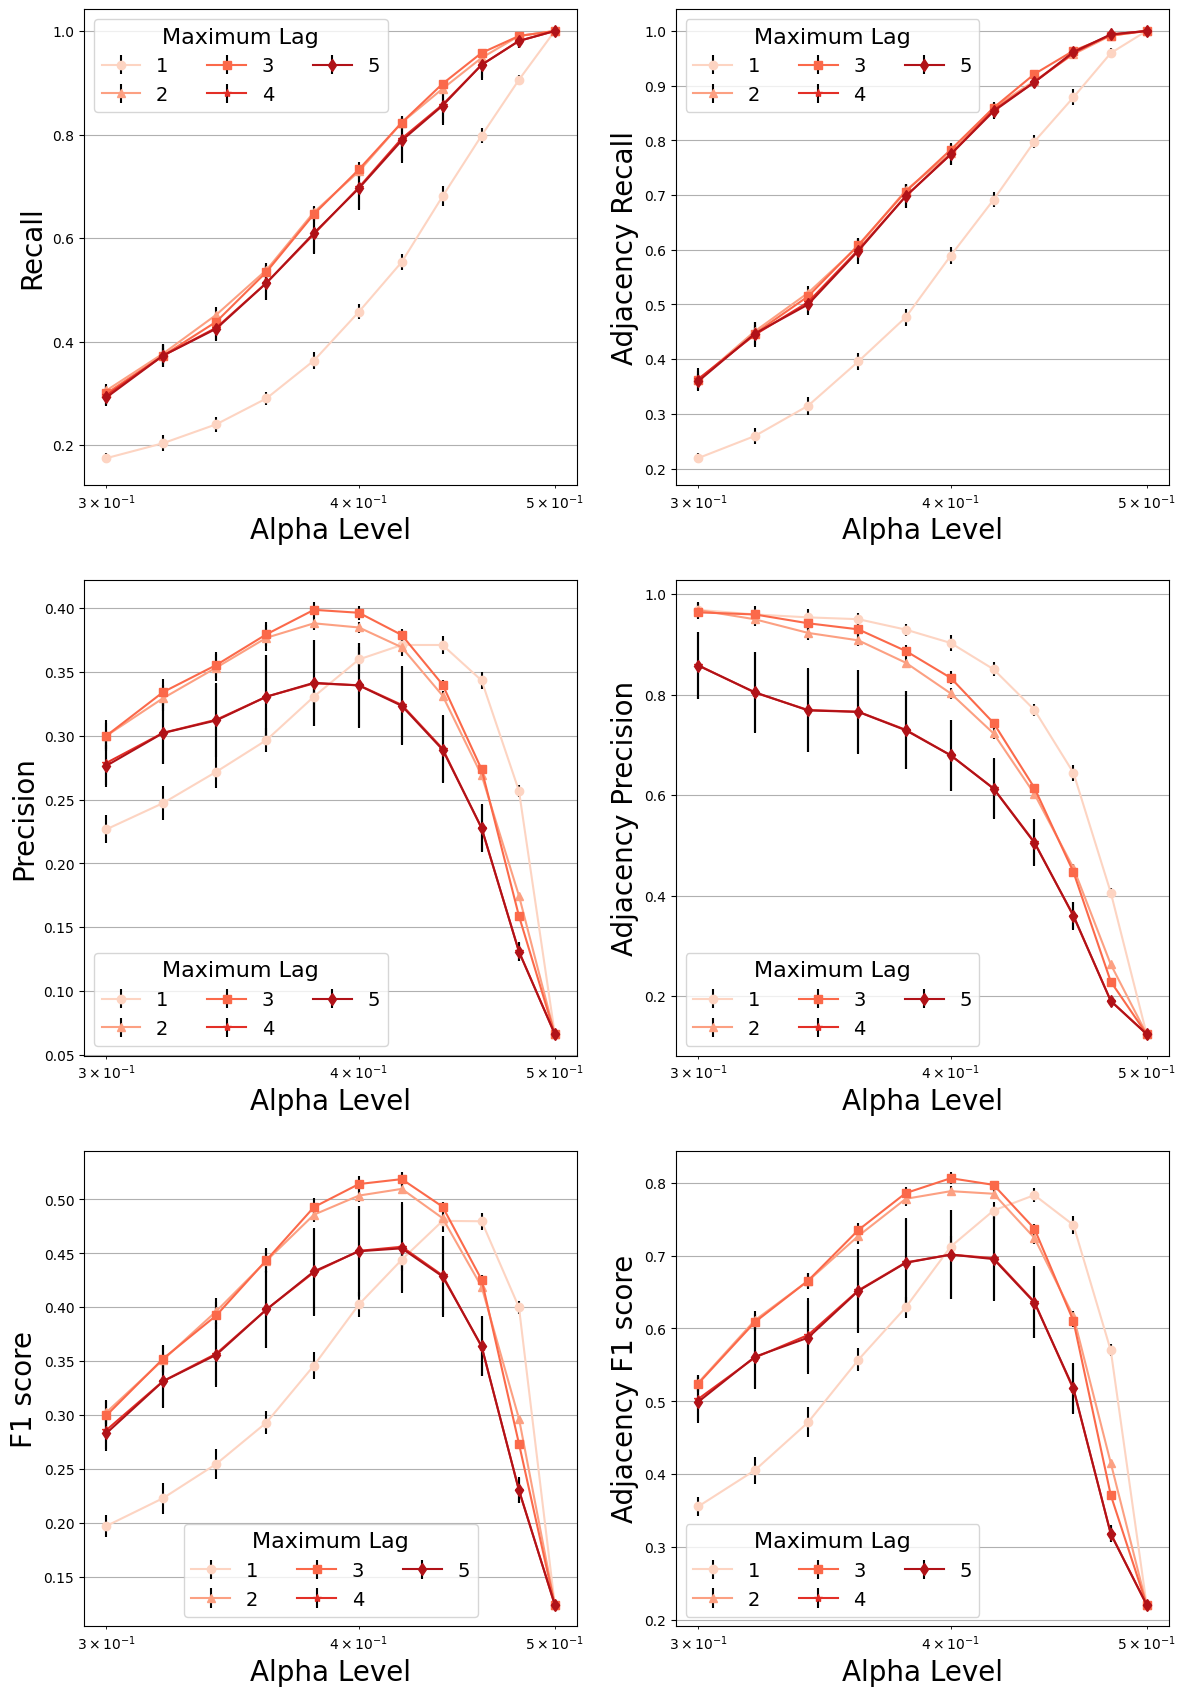

In [53]:
plt.figure(figsize = (14, 21))


for k in range(0, len(mvgc_lags)):

    mvgc_adj_recall_mean_macaque = np.zeros_like(mvgc_alpha)
    mvgc_adj_recall_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_adj_recall_median_macaque = np.zeros_like(mvgc_alpha)

    mvgc_adj_precision_mean_macaque = np.zeros_like(mvgc_alpha) 
    mvgc_adj_precision_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_adj_precision_median_macaque = np.zeros_like(mvgc_alpha) 

    mvgc_adj_F1_score_mean_macaque = np.zeros_like(mvgc_alpha) 
    mvgc_adj_F1_score_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_adj_F1_score_median_macaque = np.zeros_like(mvgc_alpha) 

    mvgc_ori_recall_mean_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_recall_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_recall_median_macaque = np.zeros_like(mvgc_alpha)

    mvgc_ori_precision_mean_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_precision_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_precision_median_macaque = np.zeros_like(mvgc_alpha)

    mvgc_ori_F1_score_mean_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_F1_score_std_macaque =np.zeros_like(mvgc_alpha)
    mvgc_ori_F1_score_median_macaque = np.zeros_like(mvgc_alpha)


    for a in range(0,len(mvgc_alpha)):

        mvgc_adj_recall_mean_macaque[a] = np.mean(np.array(mvgc_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_recall_std_macaque[a] = np.std(np.array(mvgc_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_recall_median_macaque[a] = np.median(np.array(mvgc_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])


        mvgc_adj_precision_mean_macaque[a] = np.mean(np.array(mvgc_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_precision_std_macaque[a] = np.std(np.array(mvgc_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_precision_median_macaque[a] = np.median(np.array(mvgc_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])


        mvgc_adj_F1_score_mean_macaque[a] = np.mean(np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_F1_score_std_macaque[a] = np.std(np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_F1_score_median_macaque[a] = np.median(np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])


        mvgc_ori_recall_mean_macaque[a] = np.mean(np.array(mvgc_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_recall_std_macaque[a] = np.std(np.array(mvgc_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_recall_median_macaque[a] = np.median(np.array(mvgc_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])


        mvgc_ori_precision_mean_macaque[a] = np.mean(np.array(mvgc_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_precision_std_macaque[a] = np.std(np.array(mvgc_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_precision_median_macaque[a] = np.median(np.array(mvgc_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])


        mvgc_ori_F1_score_mean_macaque[a] = np.mean(np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_F1_score_std_macaque[a] = np.std(np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_F1_score_median_macaque[a] = np.median(np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])

    mvgc_best_alpha_adj_mean= mvgc_alpha[np.argmax(mvgc_adj_F1_score_mean_macaque)]
    mvgc_best_alpha_adj_median = mvgc_alpha[np.argmax(mvgc_adj_F1_score_median_macaque)]
    mvgc_best_alpha_ori_mean = mvgc_alpha[np.argmax(mvgc_ori_F1_score_mean_macaque)]
    mvgc_best_alpha_ori_median = mvgc_alpha[np.argmax(mvgc_ori_F1_score_median_macaque)]

    plt.subplot(3,2,2)
    plt.errorbar(mvgc_alpha, mvgc_adj_recall_mean_macaque, mvgc_adj_recall_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k], color = sns.color_palette('Reds', n_colors= len(mvgc_lags))[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(mvgc_lags, fontsize = 14, loc = 'best', ncol = 3, title = 'Maximum Lag', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(mvgc_alpha, mvgc_ori_recall_mean_macaque, mvgc_ori_recall_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k], color = sns.color_palette('Reds', n_colors= len(mvgc_lags))[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(mvgc_lags, fontsize = 14, loc = 'best', ncol = 3, title = 'Maximum Lag', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(mvgc_alpha, mvgc_adj_precision_mean_macaque, mvgc_adj_precision_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k], color = sns.color_palette('Reds', n_colors= len(mvgc_lags))[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(mvgc_lags, fontsize = 14, loc = 'best', ncol = 3, title = 'Maximum Lag', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(mvgc_alpha, mvgc_ori_precision_mean_macaque, mvgc_ori_precision_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k], color = sns.color_palette('Reds', n_colors= len(mvgc_lags))[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(mvgc_lags, fontsize = 14, loc = 'best', ncol = 3, title = 'Maximum Lag', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(mvgc_alpha, mvgc_adj_F1_score_mean_macaque, mvgc_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k], color = sns.color_palette('Reds', n_colors= len(mvgc_lags))[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(mvgc_lags, fontsize = 14, loc = 'best', ncol = 3, title = 'Maximum Lag', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(mvgc_alpha, mvgc_ori_F1_score_mean_macaque, mvgc_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque_all), ecolor = 'black', fmt = markers[k], color = sns.color_palette('Reds', n_colors= len(mvgc_lags))[k])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(mvgc_lags, fontsize = 14, loc = 'best', ncol = 3, title = 'Maximum Lag', title_fontsize = 16)


## Comparison

### Performance of each method with best hyperparameters

In [54]:
# pcmci 2: called PCMCI 
pcmci_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps = np.mean(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha), axis = 0)
pcmci_adj_best_alphas_idx = np.unravel_index(pcmci_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps.argmax(), pcmci_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps.shape)
pcmci_adj_F1_scores_at_best = np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,pcmci_adj_best_alphas_idx[0], pcmci_adj_best_alphas_idx[1]]

pcmci_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps = np.mean(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha), axis = 0)
pcmci_ori_best_alphas_idx = np.unravel_index(pcmci_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps.argmax(), pcmci_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps.shape)
pcmci_ori_F1_scores_at_best = np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,pcmci_ori_best_alphas_idx[0], pcmci_ori_best_alphas_idx[1]]

print(pcmci_adj_best_alphas_idx, pcmci_ori_best_alphas_idx)

pcmci_execution_time_at_best = np.array(pcmci_macaque_execution_time)[0:num_rep_macaque,pcmci_ori_best_alphas_idx[0]]

# varlingam
varlingam_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps = np.mean(np.array(varlingam_adj_F1_score_all_rep_macaque), axis = 0)
varlingam_adj_best_alphas_idx = varlingam_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps.argmax()
varlingam_adj_F1_scores_at_best = np.array(varlingam_adj_F1_score_all_rep_macaque)[:,varlingam_adj_best_alphas_idx]

varlingam_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps = np.mean(np.array(varlingam_ori_F1_score_all_rep_macaque), axis = 0)
varlingam_ori_best_alphas_idx = varlingam_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps.argmax()
varlingam_ori_F1_scores_at_best = np.array(varlingam_ori_F1_score_all_rep_macaque)[:,varlingam_ori_best_alphas_idx]

varlingam_execution_time_at_best = np.array(varlingam_macaque_execution_time)[0:num_rep_macaque,varlingam_ori_best_alphas_idx]

# dynotears
dynotears_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps = np.mean(np.array(dynotears_adj_F1_score_all_rep_macaque), axis = 0)
dynotears_adj_best_alphas_idx = dynotears_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps.argmax()
dynotears_adj_F1_scores_at_best = np.array(dynotears_adj_F1_score_all_rep_macaque)[:,dynotears_adj_best_alphas_idx]

dynotears_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps = np.mean(np.array(dynotears_ori_F1_score_all_rep_macaque), axis = 0)
dynotears_ori_best_alphas_idx = dynotears_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps.argmax()
dynotears_ori_F1_scores_at_best = np.array(dynotears_ori_F1_score_all_rep_macaque)[:,dynotears_ori_best_alphas_idx]

dynotears_execution_time_at_best = np.array(dynotears_macaque_execution_time)[0:num_rep_macaque,dynotears_ori_best_alphas_idx]

# mvgc
mvgc_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps = np.mean(np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha), axis = 0)
mvgc_adj_best_alphas_idx = np.unravel_index(mvgc_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps.argmax(), mvgc_adj_F1_score_all_rep_macaque_both_alpha_mean_across_reps.shape)
mvgc_adj_F1_scores_at_best = np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha)[:,mvgc_adj_best_alphas_idx[0], mvgc_adj_best_alphas_idx[1]]

mvgc_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps = np.mean(np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha), axis = 0)
mvgc_ori_best_alphas_idx = np.unravel_index(mvgc_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps.argmax(), mvgc_ori_F1_score_all_rep_macaque_both_alpha_mean_across_reps.shape)
mvgc_ori_F1_scores_at_best = np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha)[:,mvgc_ori_best_alphas_idx[0], mvgc_ori_best_alphas_idx[1]]

mvgc_execution_time_at_best = np.array(mvgc_macaque_execution_time)[0:num_rep_macaque,mvgc_ori_best_alphas_idx[0], mvgc_ori_best_alphas_idx[1]]

(7, 4) (9, 6)


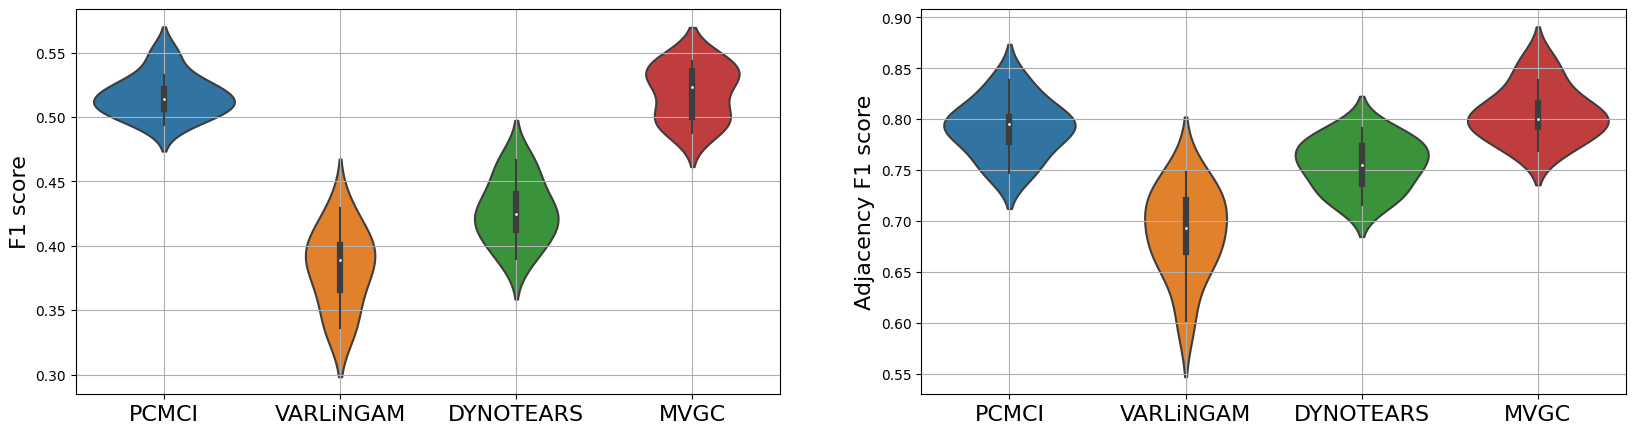

In [55]:
all_colors = ['blue', 'orange', 'green', 'red', 'purple']
labels = ['PCMCI', 'VARLiNGAM','DYNOTEARS','MVGC']

## Adjacency
plt.figure(figsize = (20,5))
ax1 = plt.subplot(1,2,2)

adj_all_methods_F1_score_dist  = []
adj_all_methods_F1_score_dist. append(np.array(pcmci_adj_F1_scores_at_best))
adj_all_methods_F1_score_dist. append(np.array(varlingam_adj_F1_scores_at_best))
adj_all_methods_F1_score_dist. append(np.array(dynotears_adj_F1_scores_at_best))
adj_all_methods_F1_score_dist. append(np.array(mvgc_adj_F1_scores_at_best))

parts = sns.violinplot(adj_all_methods_F1_score_dist, points=40, widths=0.5, showextrema=True, showmedians=True,
                    bw_method='silverman')

ax1.set_xticklabels(labels,fontsize = 16)

plt.ylabel('Adjacency F1 score',fontsize = 16)
plt.grid()


## Orientation
ax2= plt.subplot(1,2,1)

ori_all_methods_F1_score_dist  = []
ori_all_methods_F1_score_dist. append(np.array(pcmci_ori_F1_scores_at_best))
ori_all_methods_F1_score_dist. append(np.array(varlingam_ori_F1_scores_at_best))
ori_all_methods_F1_score_dist. append(np.array(dynotears_ori_F1_scores_at_best))
ori_all_methods_F1_score_dist. append(np.array(mvgc_ori_F1_scores_at_best))

parts = sns.violinplot(ori_all_methods_F1_score_dist, points=40, widths=0.5, showextrema=True, showmedians=True,
                    bw_method='silverman')

ax2.set_xticklabels(labels,fontsize = 16)

plt.ylabel('F1 score',fontsize = 16)
plt.grid()

Text(0, 0.5, 'Adjacency F1 score')

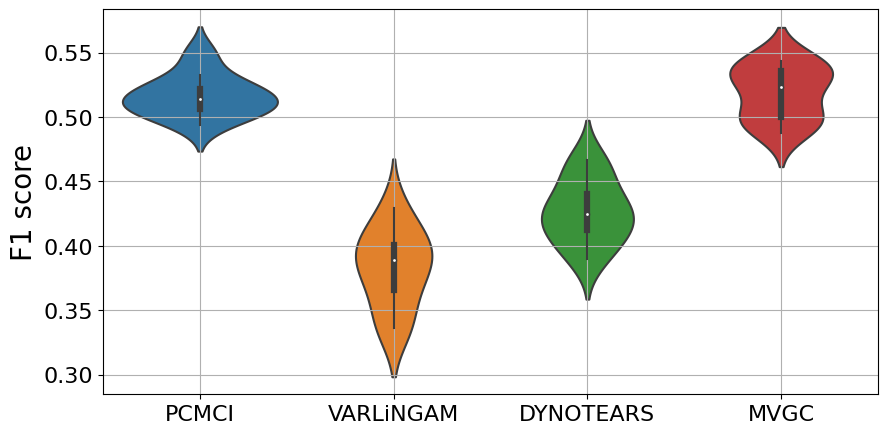

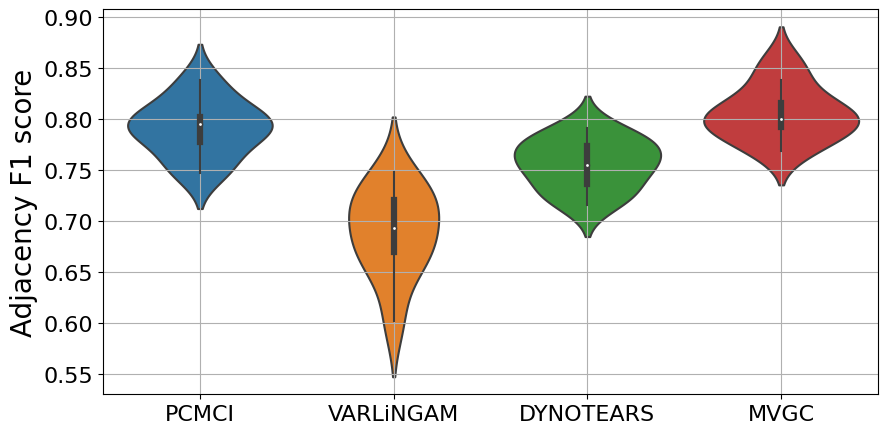

In [56]:
labels = ['PCMCI', 'VARLiNGAM','DYNOTEARS','MVGC']

## Adjacency

adj_all_methods_F1_score_dist  = []
adj_all_methods_F1_score_dist. append(np.array(pcmci_adj_F1_scores_at_best))
adj_all_methods_F1_score_dist. append(np.array(varlingam_adj_F1_scores_at_best))
adj_all_methods_F1_score_dist. append(np.array(dynotears_adj_F1_scores_at_best))
adj_all_methods_F1_score_dist. append(np.array(mvgc_adj_F1_scores_at_best))

ori_all_methods_F1_score_dist  = []
ori_all_methods_F1_score_dist. append(np.array(pcmci_ori_F1_scores_at_best))
ori_all_methods_F1_score_dist. append(np.array(varlingam_ori_F1_scores_at_best))
ori_all_methods_F1_score_dist. append(np.array(dynotears_ori_F1_scores_at_best))
ori_all_methods_F1_score_dist. append(np.array(mvgc_ori_F1_scores_at_best))


plt.figure(figsize = (10,5))
ax = plt.subplot()
parts = sns.violinplot(ori_all_methods_F1_score_dist)

ax.set_xticklabels(labels,fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('F1 score',fontsize = 20)

plt.figure(figsize = (10,5))
ax = plt.subplot()
parts = sns.violinplot(adj_all_methods_F1_score_dist)

ax.set_xticklabels(labels,fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('Adjacency F1 score',fontsize = 20)


### Execution Time Comparison

/tmp/ipykernel_2611967/4062041839.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize = 12)


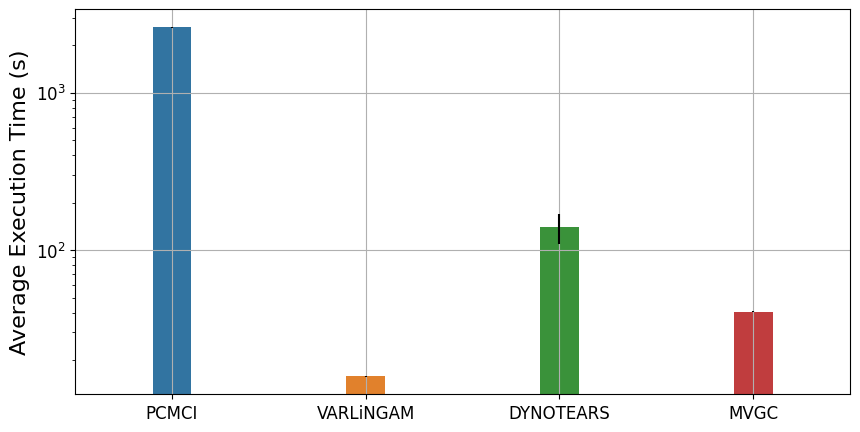

In [57]:
labels = ['PCMCI', 'VARLiNGAM','DYNOTEARS','MVGC']
palette = sns.color_palette()

# create some sample data
means = [np.mean(np.array(pcmci_execution_time_at_best)), np.mean(np.array(varlingam_execution_time_at_best)), np.mean(np.array(dynotears_execution_time_at_best)), np.mean(np.array(mvgc_execution_time_at_best))]
stds = [np.std(np.array(pcmci_execution_time_at_best)), np.std(np.array(varlingam_execution_time_at_best)), np.std(np.array(dynotears_execution_time_at_best)), np.std(np.array(mvgc_execution_time_at_best))]

# create a bar plot with error bars
plt.figure(figsize = (10,5))
ax = plt.subplot()
sns.barplot(x=labels, y=means, yerr=stds, capsize=0.5, width= 0.2)

ax.set_xticks(np.arange(len(means)))
ax.set_xticklabels(labels, fontsize = 12)
ax.set_yticklabels(labels, fontsize = 12)
ax.set_ylabel('Average Execution Time (s)', fontsize = 16)
plt.yscale('log')
ax.grid()
